In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Step 1: Define paths ---
DRIVE_CELEBA_PATH="/content/drive/MyDrive/datasets/celeba"
LOCAL_CELEBA_PATH="/content/datasets/celeba"

# --- Step 2: Create local directory ---
!mkdir -p $LOCAL_CELEBA_PATH
!echo "Local directory created at $LOCAL_CELEBA_PATH"

# --- Step 3: Copy the single ZIP file (Fast) ---
!echo "Copying image zip file from Drive..."
!cp "$DRIVE_CELEBA_PATH/img_align_celeba.zip" $LOCAL_CELEBA_PATH

# --- Step 4: Copy ALL required annotation files (Crucial Step) ---
!echo "Copying all annotation files..."
!cp "$DRIVE_CELEBA_PATH/list_attr_celeba.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_eval_partition.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/identity_CelebA.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_bbox_celeba.txt" $LOCAL_CELEBA_PATH
!cp "$DRIVE_CELEBA_PATH/list_landmarks_align_celeba.txt" $LOCAL_CELEBA_PATH

# --- Step 5: Unzip the images locally (Fast) ---
!echo "Unzipping images..."
!unzip -q "$LOCAL_CELEBA_PATH/img_align_celeba.zip" -d $LOCAL_CELEBA_PATH
!echo "Dataset setup complete!"

Local directory created at /content/datasets/celeba
Copying image zip file from Drive...
Copying all annotation files...
Unzipping images...
Dataset setup complete!


In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

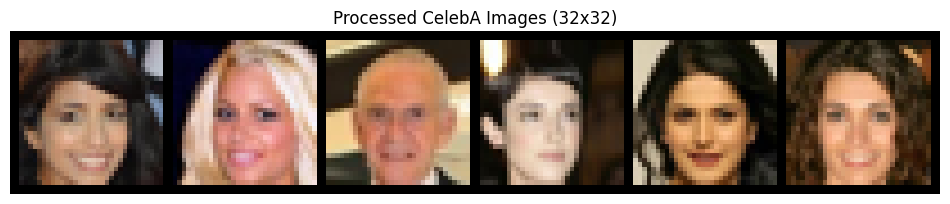

Training dataset size: 162770
Validation dataset size: 19867


In [ ]:
# For training data
train_transform = transforms.Compose([
    transforms.CenterCrop(148),
    transforms.Resize(32, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

# For validation/test data (no random flipping)
test_transform = transforms.Compose([
    transforms.CenterCrop(148),
    transforms.Resize(32, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

# Download and load the datasets
# Note: First download might take a while
root_dir = "/content/datasets"  # Change to your preferred directory

train_dataset = CelebA(
    root=root_dir,
    split="train",
    transform=train_transform,
    download=False
)

val_dataset = CelebA(
    root=root_dir,
    split="valid",
    transform=test_transform,
    download=False
)

# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12)

# Visualize some examples
def show_images(data_loader, num_images=6):
    dataiter = iter(data_loader)
    images, _ = next(dataiter)
    images = images[:num_images]

    # Convert images for display
    img_grid = torchvision.utils.make_grid(images, nrow=num_images)
    img_grid = img_grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 3))
    plt.imshow(img_grid)
    plt.title("Processed CelebA Images (32x32)")
    plt.axis('off')
    plt.show()

# Visualize a few examples
show_images(train_loader)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [8, 8, 6, 6, 4, 4, 2, 2]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RG_Flow(
  (layers): ModuleList(
    (0-1): 2 x MERABlock(
      (network): RNVPBlock(
        (s_nets): ModuleList(
          (0-7): 8 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_features=512, out_features=48, bias=True)
              )
            )
          )
        )
        (t_nets): ModuleList(
          (0-7): 8 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_fea

In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2
        return x, ldj
    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256
        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2
        logit_x = torch.log(x) - torch.log(1 - x)
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) - F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """
    model.eval()

    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)
        generated_logits, _ = model.inverse(z)
        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)

        generated_images = generated_images.cpu()

        generated_images = torch.clamp(generated_images, 0, 1)
    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')


    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show()
    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    """
    Sets up a logger that writes to a file and the console.
    """
    # Create a logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO) # Set the minimum level of messages to log

    # Prevent the logger from propagating to the root logger
    logger.propagate = False

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    # --- File Handler ---
    # Create a unique log file name with a timestamp
    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)

    # --- Console Handler ---
    stream_handler = logging.StreamHandler() # Writes to console
    stream_handler.setFormatter(formatter)

    # Add handlers to the logger, but only if they haven't been added before
    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0: # Log less frequently for a cleaner file
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

2025-06-22 17:16:10 - INFO - Training for 60 epochs...
2025-06-22 17:16:10 - INFO - Batch size: 512
2025-06-22 17:16:10 - INFO - Learning rate: 0.001
2025-06-22 17:16:10 - INFO - Image dimensions: (3, 32, 32)
2025-06-22 17:16:10 - INFO - Number of images to generate: 16
2025-06-22 17:16:10 - INFO - PriorDistribution(dist_type=Laplace)
2025-06-22 17:16:10 - INFO - --- Starting Training ---
2025-06-22 17:16:15 - INFO - Epoch: 1/60 | Batch: 0/318 | Loss (NLL): 699.8351 | BPD: 8.3287
2025-06-22 17:18:37 - INFO - Epoch: 1/60 | Batch: 50/318 | Loss (NLL): -3782.7961 | BPD: 6.2235
2025-06-22 17:20:58 - INFO - Epoch: 1/60 | Batch: 100/318 | Loss (NLL): -5146.1875 | BPD: 5.5832
2025-06-22 17:23:19 - INFO - Epoch: 1/60 | Batch: 150/318 | Loss (NLL): -5703.0972 | BPD: 5.3217
2025-06-22 17:25:39 - INFO - Epoch: 1/60 | Batch: 200/318 | Loss (NLL): -6057.0303 | BPD: 5.1555
2025-06-22 17:28:00 - INFO - Epoch: 1/60 | Batch: 250/318 | Loss (NLL): -6295.0376 | BPD: 5.0437
2025-06-22 17:30:20 - INFO - Ep

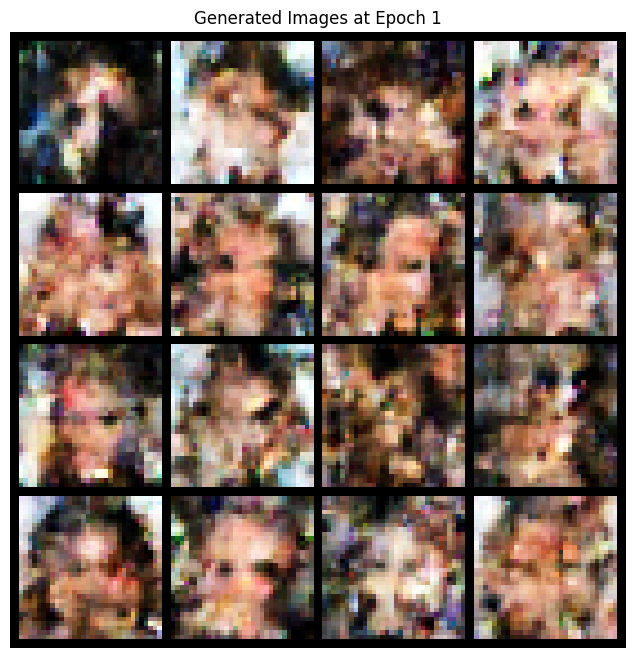

2025-06-22 17:31:09 - INFO - ------------------------------
2025-06-22 17:31:13 - INFO - Epoch: 2/60 | Batch: 0/318 | Loss (NLL): -6812.5854 | BPD: 4.8006
2025-06-22 17:33:34 - INFO - Epoch: 2/60 | Batch: 50/318 | Loss (NLL): -6828.4092 | BPD: 4.7932
2025-06-22 17:35:56 - INFO - Epoch: 2/60 | Batch: 100/318 | Loss (NLL): -6903.7119 | BPD: 4.7578
2025-06-22 17:38:19 - INFO - Epoch: 2/60 | Batch: 150/318 | Loss (NLL): -7127.5337 | BPD: 4.6527
2025-06-22 17:40:40 - INFO - Epoch: 2/60 | Batch: 200/318 | Loss (NLL): -7001.4824 | BPD: 4.7119
2025-06-22 17:43:01 - INFO - Epoch: 2/60 | Batch: 250/318 | Loss (NLL): -7170.8711 | BPD: 4.6324
2025-06-22 17:45:23 - INFO - Epoch: 2/60 | Batch: 300/318 | Loss (NLL): -7234.1548 | BPD: 4.6026
2025-06-22 17:46:11 - INFO - --- Epoch 2 Summary ---
2025-06-22 17:46:11 - INFO - Average Loss: -7032.6027 | Time: 902.10s
2025-06-22 17:46:11 - INFO - Generating sample images...


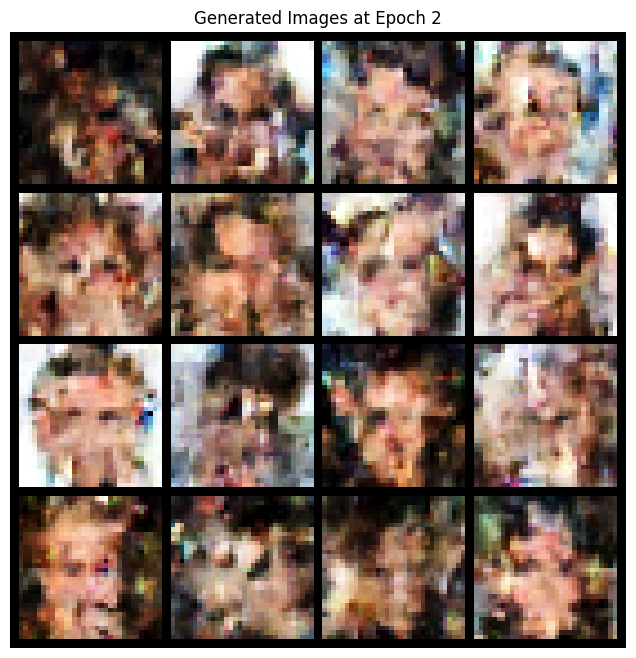

2025-06-22 17:46:11 - INFO - ------------------------------
2025-06-22 17:46:16 - INFO - Epoch: 3/60 | Batch: 0/318 | Loss (NLL): -7379.6133 | BPD: 4.5343
2025-06-22 17:48:38 - INFO - Epoch: 3/60 | Batch: 50/318 | Loss (NLL): -7401.4756 | BPD: 4.5241
2025-06-22 17:50:59 - INFO - Epoch: 3/60 | Batch: 100/318 | Loss (NLL): -7488.2227 | BPD: 4.4833
2025-06-22 17:53:20 - INFO - Epoch: 3/60 | Batch: 150/318 | Loss (NLL): -7650.8984 | BPD: 4.4069
2025-06-22 17:55:42 - INFO - Epoch: 3/60 | Batch: 200/318 | Loss (NLL): -7219.5703 | BPD: 4.6095
2025-06-22 17:58:03 - INFO - Epoch: 3/60 | Batch: 250/318 | Loss (NLL): -7482.1230 | BPD: 4.4862
2025-06-22 18:00:24 - INFO - Epoch: 3/60 | Batch: 300/318 | Loss (NLL): -7400.0947 | BPD: 4.5247
2025-06-22 18:01:12 - INFO - --- Epoch 3 Summary ---
2025-06-22 18:01:12 - INFO - Average Loss: -7430.6592 | Time: 900.80s
2025-06-22 18:01:12 - INFO - Generating sample images...


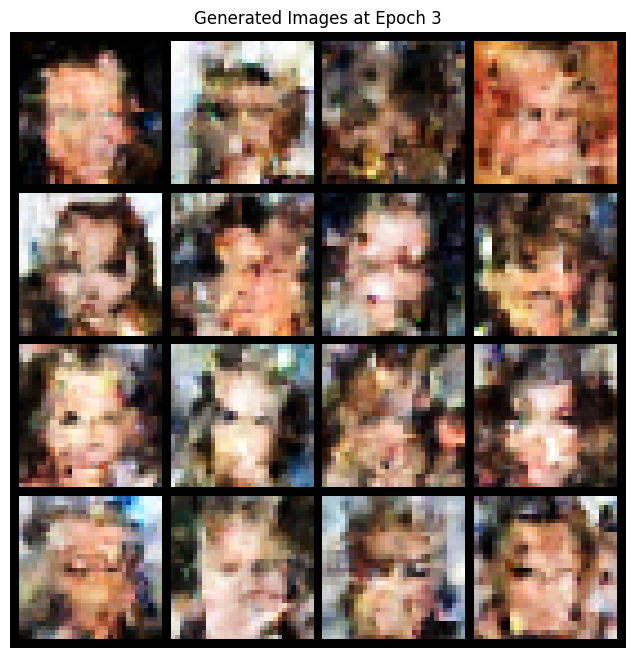

2025-06-22 18:01:13 - INFO - ------------------------------
2025-06-22 18:01:17 - INFO - Epoch: 4/60 | Batch: 0/318 | Loss (NLL): -7667.0405 | BPD: 4.3993
2025-06-22 18:03:38 - INFO - Epoch: 4/60 | Batch: 50/318 | Loss (NLL): -7405.6777 | BPD: 4.5221
2025-06-22 18:06:00 - INFO - Epoch: 4/60 | Batch: 100/318 | Loss (NLL): -7687.9365 | BPD: 4.3895
2025-06-22 18:08:21 - INFO - Epoch: 4/60 | Batch: 150/318 | Loss (NLL): -7629.2266 | BPD: 4.4171
2025-06-22 18:10:41 - INFO - Epoch: 4/60 | Batch: 200/318 | Loss (NLL): -7761.5396 | BPD: 4.3550
2025-06-22 18:13:03 - INFO - Epoch: 4/60 | Batch: 250/318 | Loss (NLL): -7736.6929 | BPD: 4.3666
2025-06-22 18:15:26 - INFO - Epoch: 4/60 | Batch: 300/318 | Loss (NLL): -7817.6665 | BPD: 4.3286
2025-06-22 18:16:14 - INFO - --- Epoch 4 Summary ---
2025-06-22 18:16:14 - INFO - Average Loss: -7631.7773 | Time: 901.33s
2025-06-22 18:16:14 - INFO - Generating sample images...


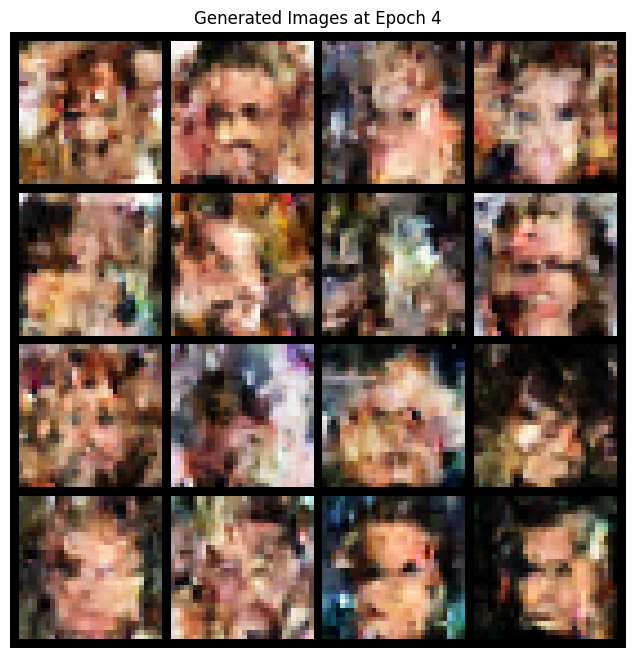

2025-06-22 18:16:14 - INFO - ------------------------------
2025-06-22 18:16:19 - INFO - Epoch: 5/60 | Batch: 0/318 | Loss (NLL): -7730.0098 | BPD: 4.3698
2025-06-22 18:18:40 - INFO - Epoch: 5/60 | Batch: 50/318 | Loss (NLL): -7663.8872 | BPD: 4.4008
2025-06-22 18:21:02 - INFO - Epoch: 5/60 | Batch: 100/318 | Loss (NLL): -7625.8306 | BPD: 4.4187
2025-06-22 18:23:23 - INFO - Epoch: 5/60 | Batch: 150/318 | Loss (NLL): -7682.5610 | BPD: 4.3921
2025-06-22 18:25:44 - INFO - Epoch: 5/60 | Batch: 200/318 | Loss (NLL): -7927.9194 | BPD: 4.2768
2025-06-22 18:28:05 - INFO - Epoch: 5/60 | Batch: 250/318 | Loss (NLL): -7657.8057 | BPD: 4.4037
2025-06-22 18:30:26 - INFO - Epoch: 5/60 | Batch: 300/318 | Loss (NLL): -7760.1406 | BPD: 4.3556
2025-06-22 18:31:14 - INFO - --- Epoch 5 Summary ---
2025-06-22 18:31:14 - INFO - Average Loss: -7745.7864 | Time: 899.34s
2025-06-22 18:31:14 - INFO - Generating sample images...


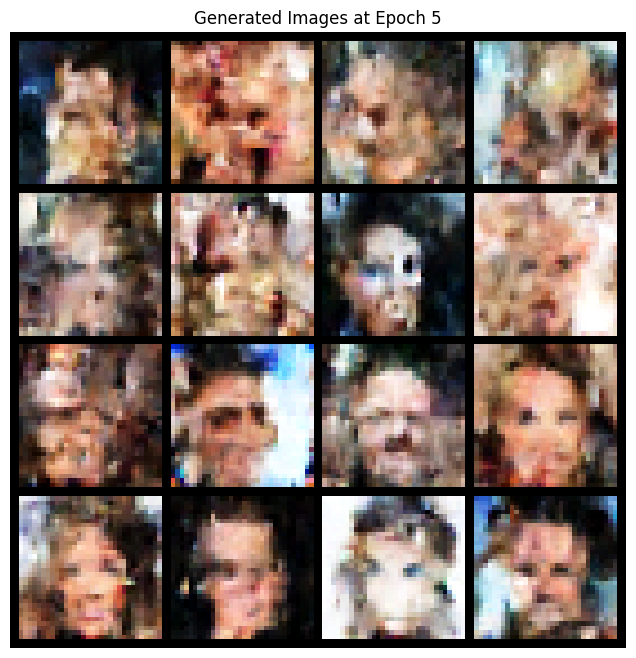

2025-06-22 18:31:14 - INFO - ------------------------------
2025-06-22 18:31:19 - INFO - Epoch: 6/60 | Batch: 0/318 | Loss (NLL): -7810.8218 | BPD: 4.3318
2025-06-22 18:33:40 - INFO - Epoch: 6/60 | Batch: 50/318 | Loss (NLL): -7899.1318 | BPD: 4.2904
2025-06-22 18:36:02 - INFO - Epoch: 6/60 | Batch: 100/318 | Loss (NLL): -7818.5581 | BPD: 4.3282
2025-06-22 18:38:24 - INFO - Epoch: 6/60 | Batch: 150/318 | Loss (NLL): -7993.3750 | BPD: 4.2461
2025-06-22 18:40:45 - INFO - Epoch: 6/60 | Batch: 200/318 | Loss (NLL): -7947.8379 | BPD: 4.2675
2025-06-22 18:43:06 - INFO - Epoch: 6/60 | Batch: 250/318 | Loss (NLL): -8008.8154 | BPD: 4.2388
2025-06-22 18:45:28 - INFO - Epoch: 6/60 | Batch: 300/318 | Loss (NLL): -7929.2373 | BPD: 4.2762
2025-06-22 18:46:15 - INFO - --- Epoch 6 Summary ---
2025-06-22 18:46:15 - INFO - Average Loss: -7861.8546 | Time: 901.13s
2025-06-22 18:46:15 - INFO - Generating sample images...


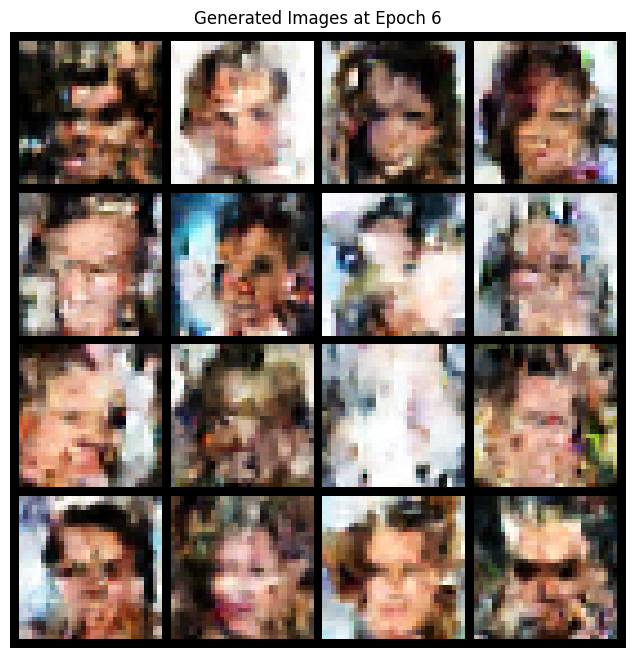

2025-06-22 18:46:16 - INFO - ------------------------------
2025-06-22 18:46:21 - INFO - Epoch: 7/60 | Batch: 0/318 | Loss (NLL): -7782.9746 | BPD: 4.3449
2025-06-22 18:48:42 - INFO - Epoch: 7/60 | Batch: 50/318 | Loss (NLL): -8062.7949 | BPD: 4.2135
2025-06-22 18:51:04 - INFO - Epoch: 7/60 | Batch: 100/318 | Loss (NLL): -7615.8716 | BPD: 4.4234
2025-06-22 18:53:24 - INFO - Epoch: 7/60 | Batch: 150/318 | Loss (NLL): -7844.4717 | BPD: 4.3160
2025-06-22 18:55:45 - INFO - Epoch: 7/60 | Batch: 200/318 | Loss (NLL): -7972.8345 | BPD: 4.2557
2025-06-22 18:58:06 - INFO - Epoch: 7/60 | Batch: 250/318 | Loss (NLL): -8014.6743 | BPD: 4.2361
2025-06-22 19:00:28 - INFO - Epoch: 7/60 | Batch: 300/318 | Loss (NLL): -7987.4316 | BPD: 4.2489
2025-06-22 19:01:16 - INFO - --- Epoch 7 Summary ---
2025-06-22 19:01:16 - INFO - Average Loss: -7922.3750 | Time: 899.91s
2025-06-22 19:01:16 - INFO - Generating sample images...


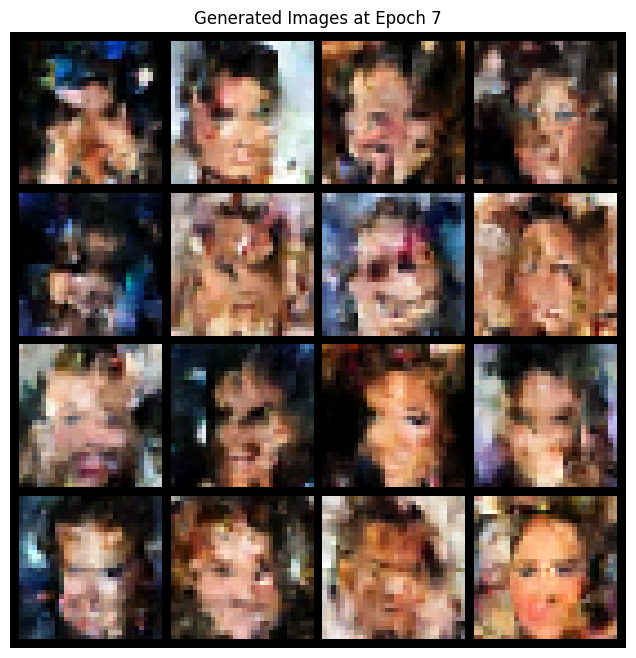

2025-06-22 19:01:16 - INFO - ------------------------------
2025-06-22 19:01:21 - INFO - Epoch: 8/60 | Batch: 0/318 | Loss (NLL): -7992.6333 | BPD: 4.2464
2025-06-22 19:03:43 - INFO - Epoch: 8/60 | Batch: 50/318 | Loss (NLL): -7953.3799 | BPD: 4.2649
2025-06-22 19:06:04 - INFO - Epoch: 8/60 | Batch: 100/318 | Loss (NLL): -7970.5415 | BPD: 4.2568
2025-06-22 19:08:25 - INFO - Epoch: 8/60 | Batch: 150/318 | Loss (NLL): -8027.2080 | BPD: 4.2302
2025-06-22 19:10:47 - INFO - Epoch: 8/60 | Batch: 200/318 | Loss (NLL): -8083.9165 | BPD: 4.2036
2025-06-22 19:13:09 - INFO - Epoch: 8/60 | Batch: 250/318 | Loss (NLL): -8085.1289 | BPD: 4.2030
2025-06-22 19:15:30 - INFO - Epoch: 8/60 | Batch: 300/318 | Loss (NLL): -8090.2607 | BPD: 4.2006
2025-06-22 19:16:18 - INFO - --- Epoch 8 Summary ---
2025-06-22 19:16:18 - INFO - Average Loss: -8043.8675 | Time: 901.44s
2025-06-22 19:16:18 - INFO - Generating sample images...


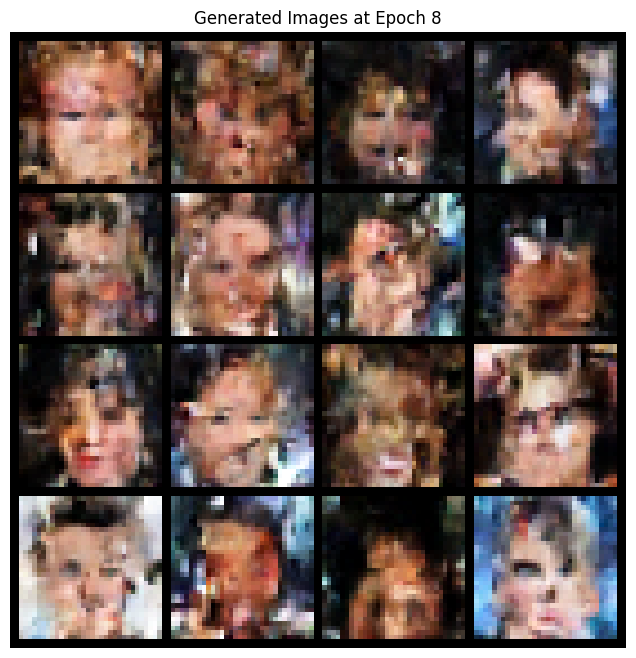

2025-06-22 19:16:18 - INFO - ------------------------------
2025-06-22 19:16:23 - INFO - Epoch: 9/60 | Batch: 0/318 | Loss (NLL): -8064.2139 | BPD: 4.2128
2025-06-22 19:18:44 - INFO - Epoch: 9/60 | Batch: 50/318 | Loss (NLL): -8044.6768 | BPD: 4.2220
2025-06-22 19:21:06 - INFO - Epoch: 9/60 | Batch: 100/318 | Loss (NLL): -7963.3774 | BPD: 4.2602
2025-06-22 19:23:27 - INFO - Epoch: 9/60 | Batch: 150/318 | Loss (NLL): -8123.3682 | BPD: 4.1850
2025-06-22 19:25:49 - INFO - Epoch: 9/60 | Batch: 200/318 | Loss (NLL): -8233.8789 | BPD: 4.1331
2025-06-22 19:28:09 - INFO - Epoch: 9/60 | Batch: 250/318 | Loss (NLL): -8076.3740 | BPD: 4.2071
2025-06-22 19:30:30 - INFO - Epoch: 9/60 | Batch: 300/318 | Loss (NLL): -8129.3467 | BPD: 4.1822
2025-06-22 19:31:18 - INFO - --- Epoch 9 Summary ---
2025-06-22 19:31:18 - INFO - Average Loss: -8108.7321 | Time: 900.04s
2025-06-22 19:31:18 - INFO - Generating sample images...


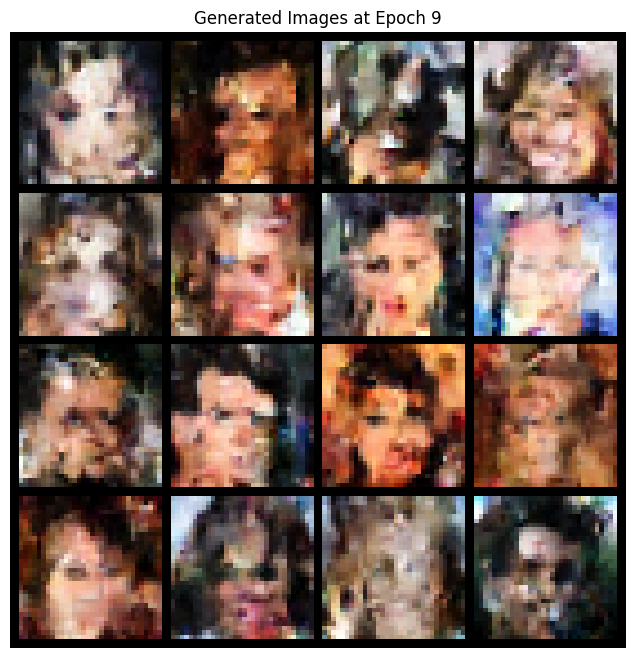

2025-06-22 19:31:19 - INFO - ------------------------------
2025-06-22 19:31:24 - INFO - Epoch: 10/60 | Batch: 0/318 | Loss (NLL): -8055.8223 | BPD: 4.2168
2025-06-22 19:33:45 - INFO - Epoch: 10/60 | Batch: 50/318 | Loss (NLL): -8004.4941 | BPD: 4.2409
2025-06-22 19:36:06 - INFO - Epoch: 10/60 | Batch: 100/318 | Loss (NLL): -8075.2021 | BPD: 4.2077
2025-06-22 19:38:27 - INFO - Epoch: 10/60 | Batch: 150/318 | Loss (NLL): -8095.9390 | BPD: 4.1979
2025-06-22 19:40:49 - INFO - Epoch: 10/60 | Batch: 200/318 | Loss (NLL): -8107.5098 | BPD: 4.1925
2025-06-22 19:43:10 - INFO - Epoch: 10/60 | Batch: 250/318 | Loss (NLL): -8159.8828 | BPD: 4.1679
2025-06-22 19:45:32 - INFO - Epoch: 10/60 | Batch: 300/318 | Loss (NLL): -8121.9917 | BPD: 4.1857
2025-06-22 19:46:20 - INFO - --- Epoch 10 Summary ---
2025-06-22 19:46:20 - INFO - Average Loss: -8163.0772 | Time: 901.52s
2025-06-22 19:46:20 - INFO - Generating sample images...


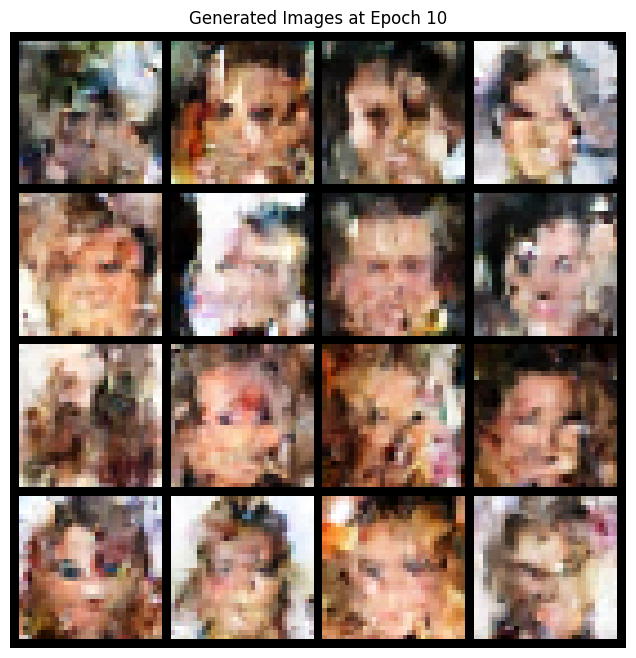

2025-06-22 19:46:21 - INFO - ------------------------------
2025-06-22 19:46:25 - INFO - Epoch: 11/60 | Batch: 0/318 | Loss (NLL): -8219.7734 | BPD: 4.1398
2025-06-22 19:48:49 - INFO - Epoch: 11/60 | Batch: 50/318 | Loss (NLL): -8238.3457 | BPD: 4.1310
2025-06-22 19:51:11 - INFO - Epoch: 11/60 | Batch: 100/318 | Loss (NLL): -8132.3208 | BPD: 4.1808
2025-06-22 19:53:32 - INFO - Epoch: 11/60 | Batch: 150/318 | Loss (NLL): -8242.1270 | BPD: 4.1293
2025-06-22 19:55:55 - INFO - Epoch: 11/60 | Batch: 200/318 | Loss (NLL): -8278.1836 | BPD: 4.1123
2025-06-22 19:58:16 - INFO - Epoch: 11/60 | Batch: 250/318 | Loss (NLL): -8188.0273 | BPD: 4.1547
2025-06-22 20:00:37 - INFO - Epoch: 11/60 | Batch: 300/318 | Loss (NLL): -8045.9355 | BPD: 4.2214
2025-06-22 20:01:25 - INFO - --- Epoch 11 Summary ---
2025-06-22 20:01:25 - INFO - Average Loss: -8223.9053 | Time: 904.45s
2025-06-22 20:01:25 - INFO - Generating sample images...


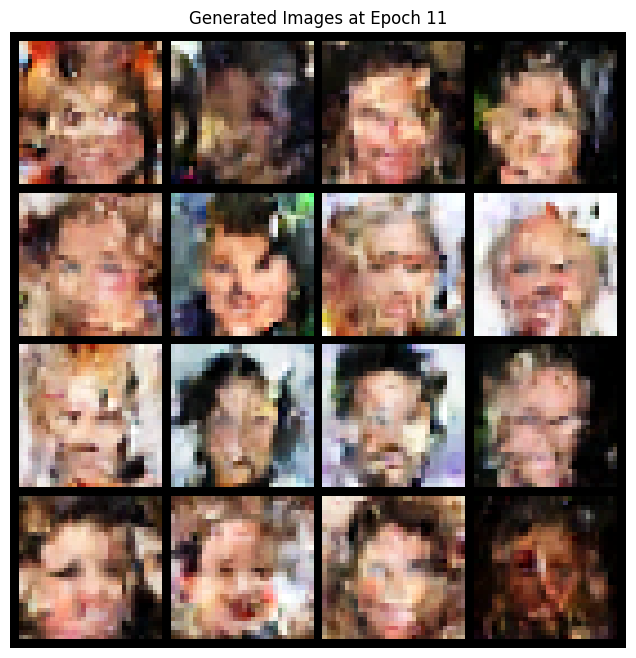

2025-06-22 20:01:26 - INFO - ------------------------------
2025-06-22 20:01:31 - INFO - Epoch: 12/60 | Batch: 0/318 | Loss (NLL): -8232.2871 | BPD: 4.1339
2025-06-22 20:03:52 - INFO - Epoch: 12/60 | Batch: 50/318 | Loss (NLL): -8328.0293 | BPD: 4.0889
2025-06-22 20:06:14 - INFO - Epoch: 12/60 | Batch: 100/318 | Loss (NLL): -8258.0312 | BPD: 4.1218
2025-06-22 20:08:35 - INFO - Epoch: 12/60 | Batch: 150/318 | Loss (NLL): -8093.9795 | BPD: 4.1988
2025-06-22 20:10:57 - INFO - Epoch: 12/60 | Batch: 200/318 | Loss (NLL): -8302.6143 | BPD: 4.1009
2025-06-22 20:13:19 - INFO - Epoch: 12/60 | Batch: 250/318 | Loss (NLL): -8318.7012 | BPD: 4.0933
2025-06-22 20:15:40 - INFO - Epoch: 12/60 | Batch: 300/318 | Loss (NLL): -8286.1172 | BPD: 4.1086
2025-06-22 20:16:28 - INFO - --- Epoch 12 Summary ---
2025-06-22 20:16:28 - INFO - Average Loss: -8279.7596 | Time: 902.63s
2025-06-22 20:16:28 - INFO - Generating sample images...


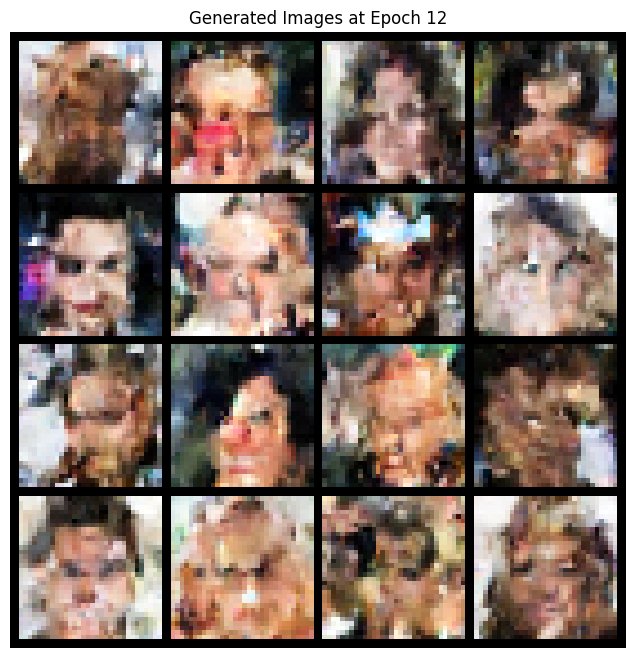

2025-06-22 20:16:29 - INFO - ------------------------------
2025-06-22 20:16:34 - INFO - Epoch: 13/60 | Batch: 0/318 | Loss (NLL): -8054.8818 | BPD: 4.2172
2025-06-22 20:18:56 - INFO - Epoch: 13/60 | Batch: 50/318 | Loss (NLL): -8306.9365 | BPD: 4.0988
2025-06-22 20:21:18 - INFO - Epoch: 13/60 | Batch: 100/318 | Loss (NLL): -8214.0410 | BPD: 4.1425
2025-06-22 20:23:40 - INFO - Epoch: 13/60 | Batch: 150/318 | Loss (NLL): -8375.5127 | BPD: 4.0666
2025-06-22 20:26:04 - INFO - Epoch: 13/60 | Batch: 200/318 | Loss (NLL): -8310.2324 | BPD: 4.0973
2025-06-22 20:28:27 - INFO - Epoch: 13/60 | Batch: 250/318 | Loss (NLL): -8301.8672 | BPD: 4.1012
2025-06-22 20:30:49 - INFO - Epoch: 13/60 | Batch: 300/318 | Loss (NLL): -8444.9258 | BPD: 4.0340
2025-06-22 20:31:37 - INFO - --- Epoch 13 Summary ---
2025-06-22 20:31:37 - INFO - Average Loss: -8309.9345 | Time: 908.29s
2025-06-22 20:31:37 - INFO - Generating sample images...


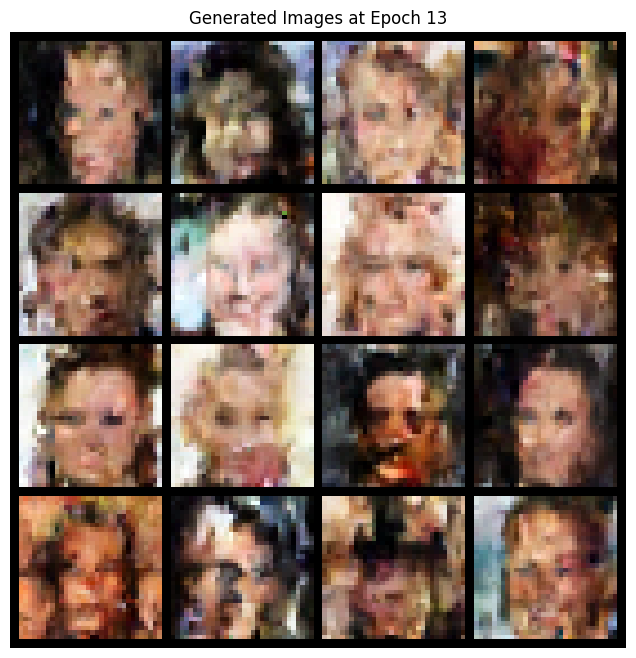

2025-06-22 20:31:38 - INFO - ------------------------------
2025-06-22 20:31:42 - INFO - Epoch: 14/60 | Batch: 0/318 | Loss (NLL): -8356.3320 | BPD: 4.0756
2025-06-22 20:34:05 - INFO - Epoch: 14/60 | Batch: 50/318 | Loss (NLL): -8080.2944 | BPD: 4.2053
2025-06-22 20:36:27 - INFO - Epoch: 14/60 | Batch: 100/318 | Loss (NLL): -8402.1318 | BPD: 4.0541
2025-06-22 20:38:49 - INFO - Epoch: 14/60 | Batch: 150/318 | Loss (NLL): -8312.0488 | BPD: 4.0964
2025-06-22 20:41:12 - INFO - Epoch: 14/60 | Batch: 200/318 | Loss (NLL): -8402.8652 | BPD: 4.0538
2025-06-22 20:43:34 - INFO - Epoch: 14/60 | Batch: 250/318 | Loss (NLL): -8404.6670 | BPD: 4.0529
2025-06-22 20:45:55 - INFO - Epoch: 14/60 | Batch: 300/318 | Loss (NLL): -8189.5796 | BPD: 4.1539
2025-06-22 20:46:43 - INFO - --- Epoch 14 Summary ---
2025-06-22 20:46:43 - INFO - Average Loss: -8319.8082 | Time: 905.31s
2025-06-22 20:46:43 - INFO - Generating sample images...


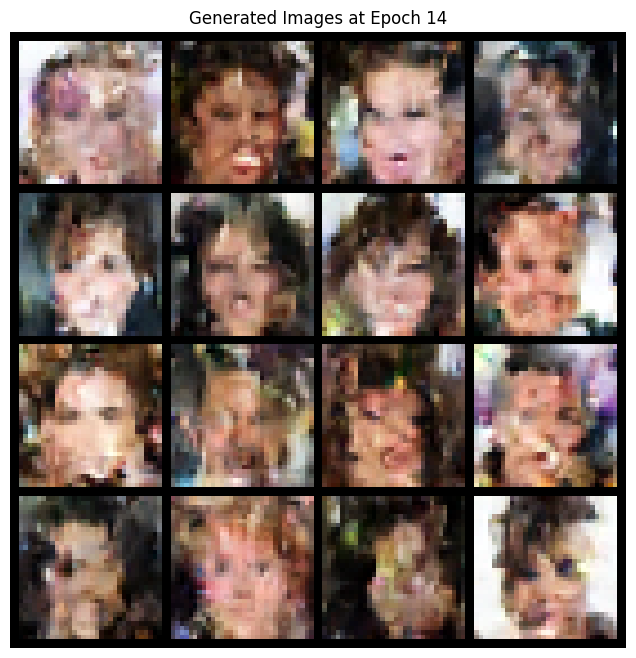

2025-06-22 20:46:44 - INFO - ------------------------------
2025-06-22 20:46:48 - INFO - Epoch: 15/60 | Batch: 0/318 | Loss (NLL): -8370.8379 | BPD: 4.0688
2025-06-22 20:49:09 - INFO - Epoch: 15/60 | Batch: 50/318 | Loss (NLL): -8383.5762 | BPD: 4.0628
2025-06-22 20:51:31 - INFO - Epoch: 15/60 | Batch: 100/318 | Loss (NLL): -8280.0400 | BPD: 4.1115
2025-06-22 20:53:53 - INFO - Epoch: 15/60 | Batch: 150/318 | Loss (NLL): -8332.1348 | BPD: 4.0870
2025-06-22 20:56:16 - INFO - Epoch: 15/60 | Batch: 200/318 | Loss (NLL): -8383.3379 | BPD: 4.0630
2025-06-22 20:58:38 - INFO - Epoch: 15/60 | Batch: 250/318 | Loss (NLL): -8374.3418 | BPD: 4.0672
2025-06-22 21:00:59 - INFO - Epoch: 15/60 | Batch: 300/318 | Loss (NLL): -8348.7588 | BPD: 4.0792
2025-06-22 21:01:47 - INFO - --- Epoch 15 Summary ---
2025-06-22 21:01:47 - INFO - Average Loss: -8363.4274 | Time: 903.43s
2025-06-22 21:01:47 - INFO - Generating sample images...


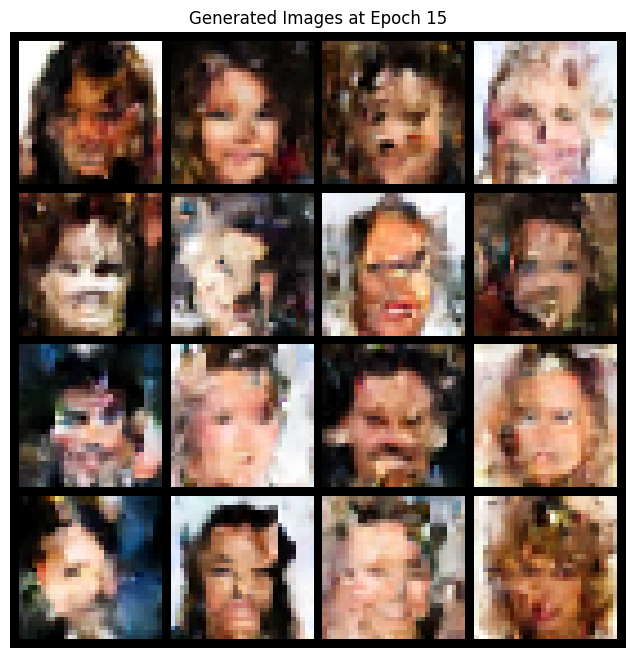

2025-06-22 21:01:48 - INFO - ------------------------------
2025-06-22 21:01:52 - INFO - Epoch: 16/60 | Batch: 0/318 | Loss (NLL): -8338.8320 | BPD: 4.0839
2025-06-22 21:04:15 - INFO - Epoch: 16/60 | Batch: 50/318 | Loss (NLL): -8441.5078 | BPD: 4.0356
2025-06-22 21:06:37 - INFO - Epoch: 16/60 | Batch: 100/318 | Loss (NLL): -8415.3848 | BPD: 4.0479
2025-06-22 21:08:58 - INFO - Epoch: 16/60 | Batch: 150/318 | Loss (NLL): -8465.6113 | BPD: 4.0243
2025-06-22 21:11:20 - INFO - Epoch: 16/60 | Batch: 200/318 | Loss (NLL): -8405.3535 | BPD: 4.0526
2025-06-22 21:13:41 - INFO - Epoch: 16/60 | Batch: 250/318 | Loss (NLL): -8482.2871 | BPD: 4.0165
2025-06-22 21:16:03 - INFO - Epoch: 16/60 | Batch: 300/318 | Loss (NLL): -8405.5889 | BPD: 4.0525
2025-06-22 21:16:51 - INFO - --- Epoch 16 Summary ---
2025-06-22 21:16:51 - INFO - Average Loss: -8399.6852 | Time: 903.11s
2025-06-22 21:16:51 - INFO - Generating sample images...


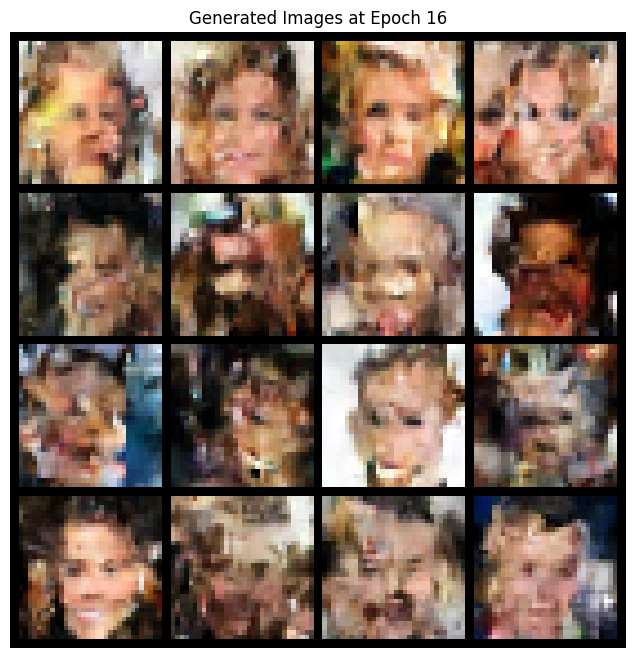

2025-06-22 21:16:51 - INFO - ------------------------------
2025-06-22 21:16:56 - INFO - Epoch: 17/60 | Batch: 0/318 | Loss (NLL): -8419.4092 | BPD: 4.0460
2025-06-22 21:19:18 - INFO - Epoch: 17/60 | Batch: 50/318 | Loss (NLL): -8437.1211 | BPD: 4.0377
2025-06-22 21:21:41 - INFO - Epoch: 17/60 | Batch: 100/318 | Loss (NLL): -8432.3906 | BPD: 4.0399
2025-06-22 21:24:04 - INFO - Epoch: 17/60 | Batch: 150/318 | Loss (NLL): -8365.3164 | BPD: 4.0714
2025-06-22 21:26:26 - INFO - Epoch: 17/60 | Batch: 200/318 | Loss (NLL): -8389.2529 | BPD: 4.0602
2025-06-22 21:28:47 - INFO - Epoch: 17/60 | Batch: 250/318 | Loss (NLL): -8556.6572 | BPD: 3.9816
2025-06-22 21:31:09 - INFO - Epoch: 17/60 | Batch: 300/318 | Loss (NLL): -8393.0684 | BPD: 4.0584
2025-06-22 21:31:57 - INFO - --- Epoch 17 Summary ---
2025-06-22 21:31:57 - INFO - Average Loss: -8447.0360 | Time: 906.19s
2025-06-22 21:31:57 - INFO - Generating sample images...


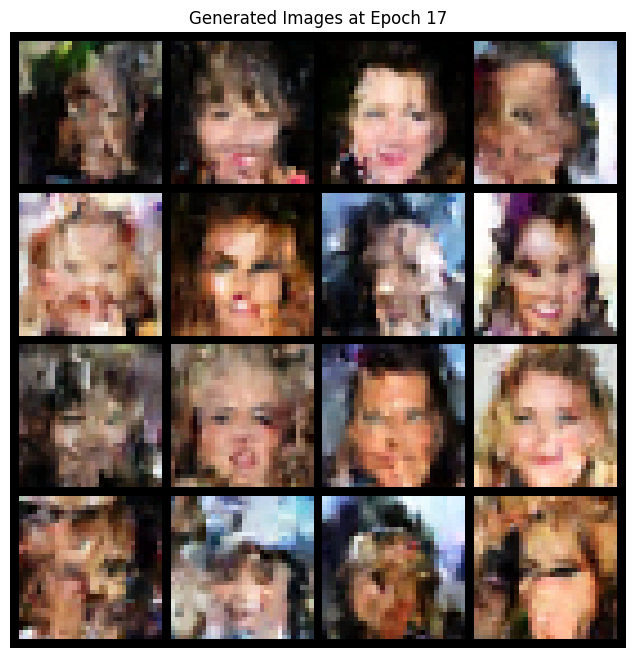

2025-06-22 21:31:58 - INFO - ------------------------------
2025-06-22 21:32:03 - INFO - Epoch: 18/60 | Batch: 0/318 | Loss (NLL): -8335.2051 | BPD: 4.0856
2025-06-22 21:34:24 - INFO - Epoch: 18/60 | Batch: 50/318 | Loss (NLL): -8479.5859 | BPD: 4.0178
2025-06-22 21:36:46 - INFO - Epoch: 18/60 | Batch: 100/318 | Loss (NLL): -8483.3379 | BPD: 4.0160
2025-06-22 21:39:08 - INFO - Epoch: 18/60 | Batch: 150/318 | Loss (NLL): -8497.5283 | BPD: 4.0093
2025-06-22 21:41:30 - INFO - Epoch: 18/60 | Batch: 200/318 | Loss (NLL): -8547.3809 | BPD: 3.9859
2025-06-22 21:43:52 - INFO - Epoch: 18/60 | Batch: 250/318 | Loss (NLL): -8487.1230 | BPD: 4.0142
2025-06-22 21:46:14 - INFO - Epoch: 18/60 | Batch: 300/318 | Loss (NLL): -8472.5996 | BPD: 4.0210
2025-06-22 21:47:02 - INFO - --- Epoch 18 Summary ---
2025-06-22 21:47:02 - INFO - Average Loss: -8456.4176 | Time: 904.30s
2025-06-22 21:47:02 - INFO - Generating sample images...


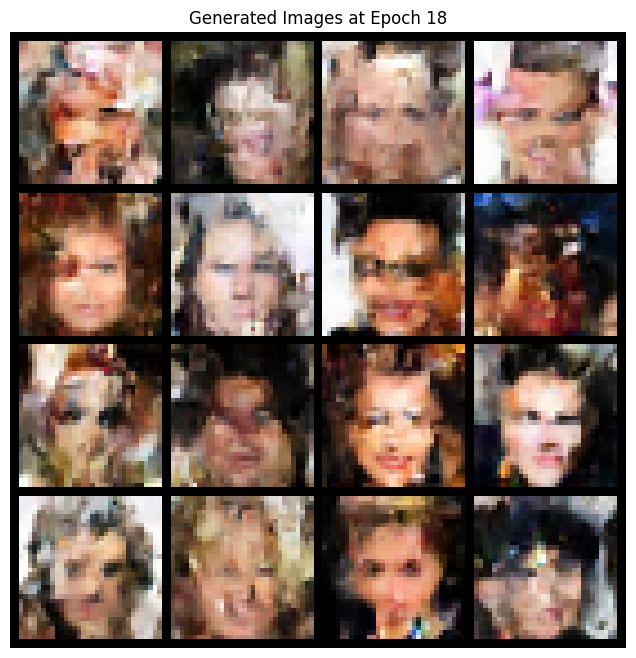

2025-06-22 21:47:03 - INFO - ------------------------------
2025-06-22 21:47:07 - INFO - Epoch: 19/60 | Batch: 0/318 | Loss (NLL): -8513.0723 | BPD: 4.0020
2025-06-22 21:49:29 - INFO - Epoch: 19/60 | Batch: 50/318 | Loss (NLL): -8455.8926 | BPD: 4.0289
2025-06-22 21:51:51 - INFO - Epoch: 19/60 | Batch: 100/318 | Loss (NLL): -8545.9658 | BPD: 3.9866
2025-06-22 21:54:13 - INFO - Epoch: 19/60 | Batch: 150/318 | Loss (NLL): -8433.2910 | BPD: 4.0395
2025-06-22 21:56:34 - INFO - Epoch: 19/60 | Batch: 200/318 | Loss (NLL): -8486.4727 | BPD: 4.0145
2025-06-22 21:58:56 - INFO - Epoch: 19/60 | Batch: 250/318 | Loss (NLL): -8503.2168 | BPD: 4.0067
2025-06-22 22:01:18 - INFO - Epoch: 19/60 | Batch: 300/318 | Loss (NLL): -8441.2705 | BPD: 4.0357
2025-06-22 22:02:06 - INFO - --- Epoch 19 Summary ---
2025-06-22 22:02:06 - INFO - Average Loss: -8474.2144 | Time: 903.11s
2025-06-22 22:02:06 - INFO - Generating sample images...


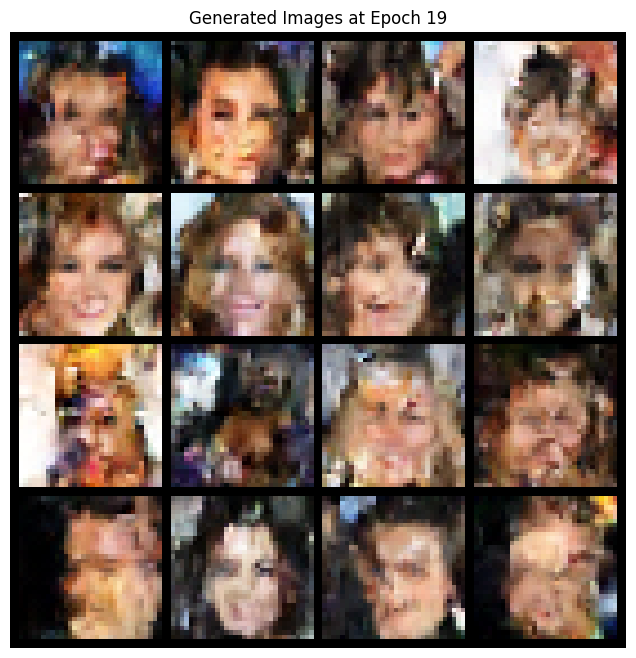

2025-06-22 22:02:06 - INFO - ------------------------------
2025-06-22 22:02:11 - INFO - Epoch: 20/60 | Batch: 0/318 | Loss (NLL): -8457.7324 | BPD: 4.0280
2025-06-22 22:04:33 - INFO - Epoch: 20/60 | Batch: 50/318 | Loss (NLL): -8486.7578 | BPD: 4.0144
2025-06-22 22:06:54 - INFO - Epoch: 20/60 | Batch: 100/318 | Loss (NLL): -8518.2832 | BPD: 3.9996
2025-06-22 22:09:16 - INFO - Epoch: 20/60 | Batch: 150/318 | Loss (NLL): -8494.9160 | BPD: 4.0106
2025-06-22 22:11:38 - INFO - Epoch: 20/60 | Batch: 200/318 | Loss (NLL): -8530.3320 | BPD: 3.9939
2025-06-22 22:14:00 - INFO - Epoch: 20/60 | Batch: 250/318 | Loss (NLL): -8441.8105 | BPD: 4.0355
2025-06-22 22:16:22 - INFO - Epoch: 20/60 | Batch: 300/318 | Loss (NLL): -8493.9668 | BPD: 4.0110
2025-06-22 22:17:09 - INFO - --- Epoch 20 Summary ---
2025-06-22 22:17:09 - INFO - Average Loss: -8507.9227 | Time: 903.02s
2025-06-22 22:17:09 - INFO - Generating sample images...


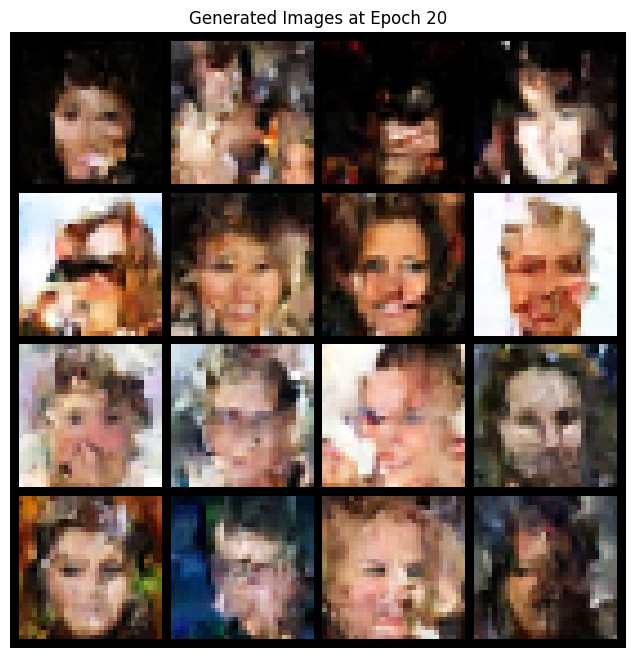

2025-06-22 22:17:10 - INFO - ------------------------------
2025-06-22 22:17:15 - INFO - Epoch: 21/60 | Batch: 0/318 | Loss (NLL): -8460.4785 | BPD: 4.0267
2025-06-22 22:19:36 - INFO - Epoch: 21/60 | Batch: 50/318 | Loss (NLL): -8558.9922 | BPD: 3.9805
2025-06-22 22:21:57 - INFO - Epoch: 21/60 | Batch: 100/318 | Loss (NLL): -8488.6543 | BPD: 4.0135
2025-06-22 22:24:18 - INFO - Epoch: 21/60 | Batch: 150/318 | Loss (NLL): -8553.0527 | BPD: 3.9833
2025-06-22 22:26:40 - INFO - Epoch: 21/60 | Batch: 200/318 | Loss (NLL): -8519.4785 | BPD: 3.9990
2025-06-22 22:29:02 - INFO - Epoch: 21/60 | Batch: 250/318 | Loss (NLL): -8479.0117 | BPD: 4.0180
2025-06-22 22:31:24 - INFO - Epoch: 21/60 | Batch: 300/318 | Loss (NLL): -8453.4258 | BPD: 4.0300
2025-06-22 22:32:12 - INFO - --- Epoch 21 Summary ---
2025-06-22 22:32:12 - INFO - Average Loss: -8526.6630 | Time: 902.35s
2025-06-22 22:32:12 - INFO - Generating sample images...


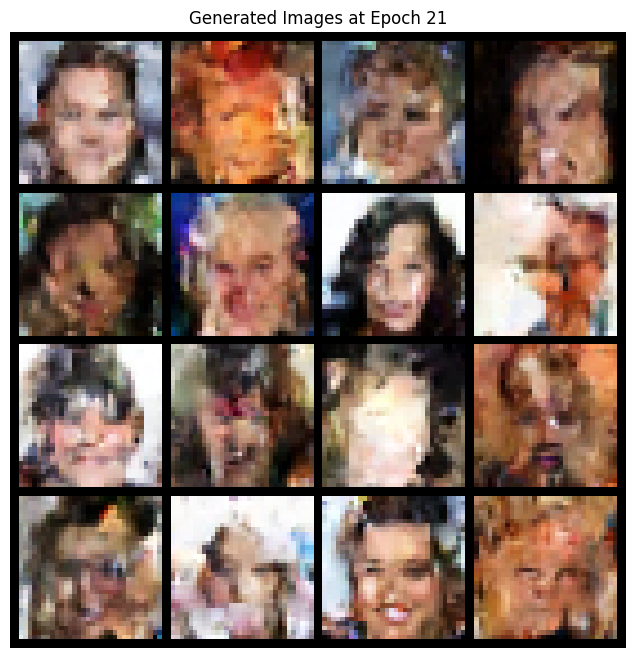

2025-06-22 22:32:13 - INFO - ------------------------------
2025-06-22 22:32:17 - INFO - Epoch: 22/60 | Batch: 0/318 | Loss (NLL): -8599.7871 | BPD: 3.9613
2025-06-22 22:34:40 - INFO - Epoch: 22/60 | Batch: 50/318 | Loss (NLL): -8515.3301 | BPD: 4.0010
2025-06-22 22:37:02 - INFO - Epoch: 22/60 | Batch: 100/318 | Loss (NLL): -8627.2539 | BPD: 3.9484
2025-06-22 22:39:24 - INFO - Epoch: 22/60 | Batch: 150/318 | Loss (NLL): -8479.6592 | BPD: 4.0177
2025-06-22 22:41:46 - INFO - Epoch: 22/60 | Batch: 200/318 | Loss (NLL): -8574.0010 | BPD: 3.9734
2025-06-22 22:44:08 - INFO - Epoch: 22/60 | Batch: 250/318 | Loss (NLL): -8533.4385 | BPD: 3.9925
2025-06-22 22:46:30 - INFO - Epoch: 22/60 | Batch: 300/318 | Loss (NLL): -8508.4199 | BPD: 4.0042
2025-06-22 22:47:18 - INFO - --- Epoch 22 Summary ---
2025-06-22 22:47:18 - INFO - Average Loss: -8545.5723 | Time: 904.93s
2025-06-22 22:47:18 - INFO - Generating sample images...


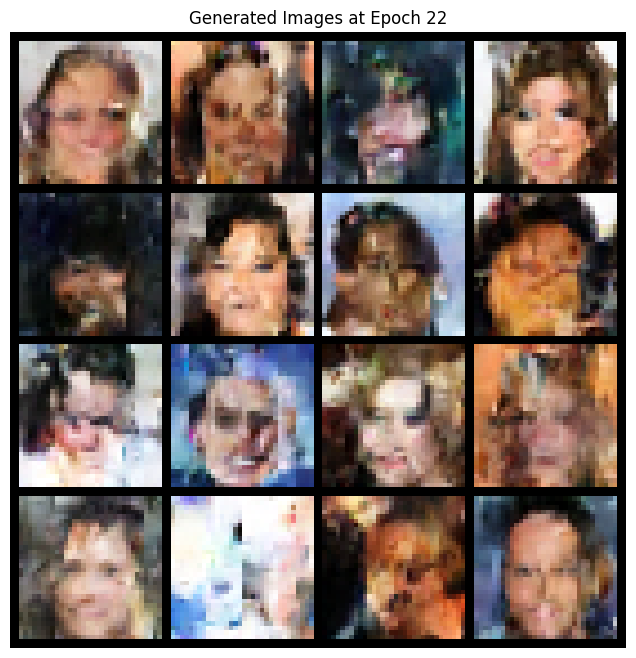

2025-06-22 22:47:18 - INFO - ------------------------------
2025-06-22 22:47:23 - INFO - Epoch: 23/60 | Batch: 0/318 | Loss (NLL): -8525.9316 | BPD: 3.9960
2025-06-22 22:49:45 - INFO - Epoch: 23/60 | Batch: 50/318 | Loss (NLL): -8646.4414 | BPD: 3.9394
2025-06-22 22:52:07 - INFO - Epoch: 23/60 | Batch: 100/318 | Loss (NLL): -8602.3613 | BPD: 3.9601
2025-06-22 22:54:29 - INFO - Epoch: 23/60 | Batch: 150/318 | Loss (NLL): -8602.9717 | BPD: 3.9598
2025-06-22 22:56:51 - INFO - Epoch: 23/60 | Batch: 200/318 | Loss (NLL): -8624.5801 | BPD: 3.9497
2025-06-22 22:59:12 - INFO - Epoch: 23/60 | Batch: 250/318 | Loss (NLL): -8629.0225 | BPD: 3.9476
2025-06-22 23:01:35 - INFO - Epoch: 23/60 | Batch: 300/318 | Loss (NLL): -8455.8457 | BPD: 4.0289
2025-06-22 23:02:23 - INFO - --- Epoch 23 Summary ---
2025-06-22 23:02:23 - INFO - Average Loss: -8580.2879 | Time: 905.16s
2025-06-22 23:02:23 - INFO - Generating sample images...


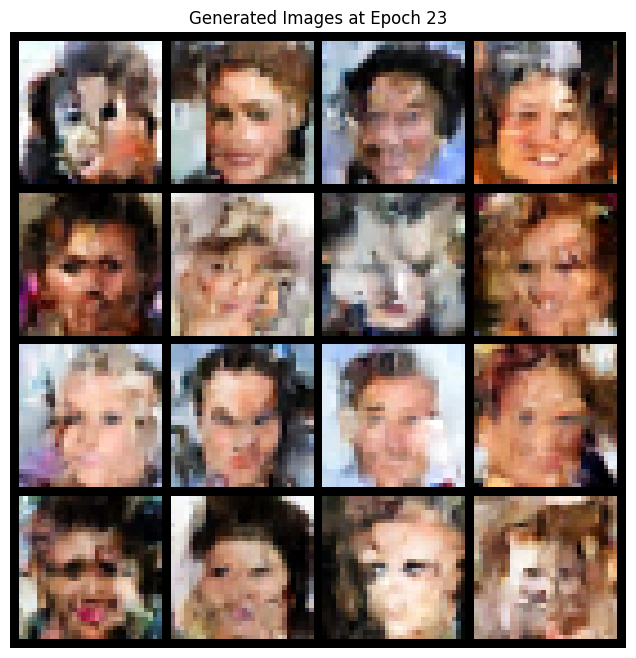

2025-06-22 23:02:24 - INFO - ------------------------------
2025-06-22 23:02:29 - INFO - Epoch: 24/60 | Batch: 0/318 | Loss (NLL): -8581.5527 | BPD: 3.9699
2025-06-22 23:04:50 - INFO - Epoch: 24/60 | Batch: 50/318 | Loss (NLL): -8604.1582 | BPD: 3.9593
2025-06-22 23:07:12 - INFO - Epoch: 24/60 | Batch: 100/318 | Loss (NLL): -8581.9482 | BPD: 3.9697
2025-06-22 23:09:34 - INFO - Epoch: 24/60 | Batch: 150/318 | Loss (NLL): -8565.4170 | BPD: 3.9774
2025-06-22 23:11:58 - INFO - Epoch: 24/60 | Batch: 200/318 | Loss (NLL): -8656.2373 | BPD: 3.9348
2025-06-22 23:14:20 - INFO - Epoch: 24/60 | Batch: 250/318 | Loss (NLL): -8690.5762 | BPD: 3.9187
2025-06-22 23:16:44 - INFO - Epoch: 24/60 | Batch: 300/318 | Loss (NLL): -8629.2959 | BPD: 3.9474
2025-06-22 23:17:32 - INFO - --- Epoch 24 Summary ---
2025-06-22 23:17:32 - INFO - Average Loss: -8594.6884 | Time: 908.67s
2025-06-22 23:17:32 - INFO - Generating sample images...


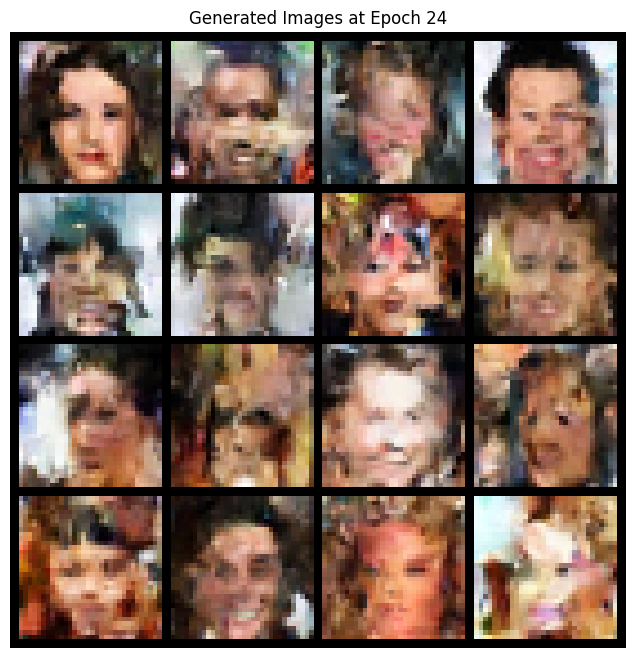

2025-06-22 23:17:33 - INFO - ------------------------------
2025-06-22 23:17:38 - INFO - Epoch: 25/60 | Batch: 0/318 | Loss (NLL): -8687.4131 | BPD: 3.9202
2025-06-22 23:20:00 - INFO - Epoch: 25/60 | Batch: 50/318 | Loss (NLL): -8431.1758 | BPD: 4.0405
2025-06-22 23:22:22 - INFO - Epoch: 25/60 | Batch: 100/318 | Loss (NLL): -8708.9521 | BPD: 3.9100
2025-06-22 23:24:45 - INFO - Epoch: 25/60 | Batch: 150/318 | Loss (NLL): -8575.4785 | BPD: 3.9727
2025-06-22 23:27:08 - INFO - Epoch: 25/60 | Batch: 200/318 | Loss (NLL): -8525.4121 | BPD: 3.9962
2025-06-22 23:29:30 - INFO - Epoch: 25/60 | Batch: 250/318 | Loss (NLL): -8676.7002 | BPD: 3.9252
2025-06-22 23:31:52 - INFO - Epoch: 25/60 | Batch: 300/318 | Loss (NLL): -8643.5947 | BPD: 3.9407
2025-06-22 23:32:41 - INFO - --- Epoch 25 Summary ---
2025-06-22 23:32:41 - INFO - Average Loss: -8610.4023 | Time: 907.57s
2025-06-22 23:32:41 - INFO - Generating sample images...


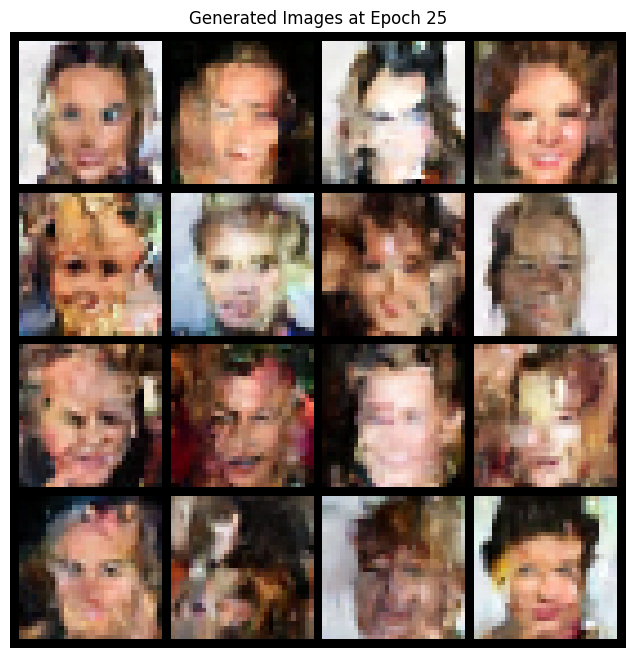

2025-06-22 23:32:41 - INFO - ------------------------------
2025-06-22 23:32:46 - INFO - Epoch: 26/60 | Batch: 0/318 | Loss (NLL): -8597.9844 | BPD: 3.9622
2025-06-22 23:35:09 - INFO - Epoch: 26/60 | Batch: 50/318 | Loss (NLL): -8696.4355 | BPD: 3.9159
2025-06-22 23:37:31 - INFO - Epoch: 26/60 | Batch: 100/318 | Loss (NLL): -8500.2852 | BPD: 4.0080
2025-06-22 23:39:53 - INFO - Epoch: 26/60 | Batch: 150/318 | Loss (NLL): -8564.0547 | BPD: 3.9781
2025-06-22 23:42:15 - INFO - Epoch: 26/60 | Batch: 200/318 | Loss (NLL): -8588.5469 | BPD: 3.9666
2025-06-22 23:44:37 - INFO - Epoch: 26/60 | Batch: 250/318 | Loss (NLL): -8643.8857 | BPD: 3.9406
2025-06-22 23:46:58 - INFO - Epoch: 26/60 | Batch: 300/318 | Loss (NLL): -8558.2441 | BPD: 3.9808
2025-06-22 23:47:47 - INFO - --- Epoch 26 Summary ---
2025-06-22 23:47:47 - INFO - Average Loss: -8617.7530 | Time: 905.73s
2025-06-22 23:47:47 - INFO - Generating sample images...


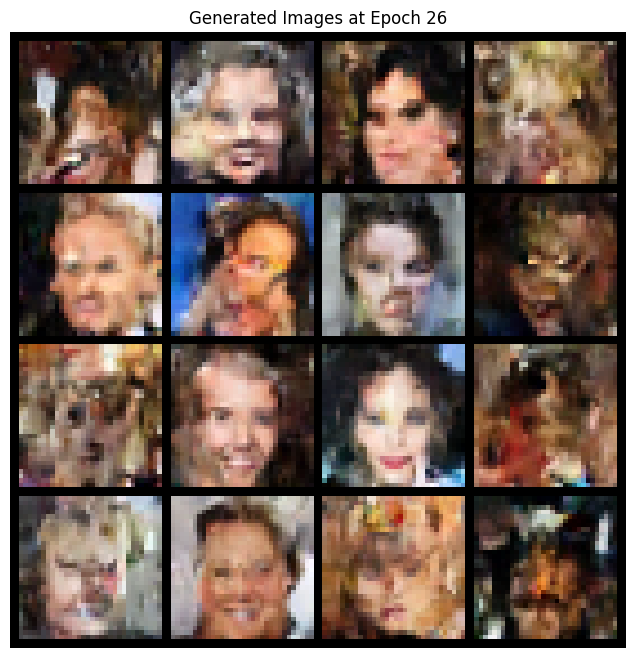

2025-06-22 23:47:47 - INFO - ------------------------------
2025-06-22 23:47:52 - INFO - Epoch: 27/60 | Batch: 0/318 | Loss (NLL): -8571.4854 | BPD: 3.9746
2025-06-22 23:50:14 - INFO - Epoch: 27/60 | Batch: 50/318 | Loss (NLL): -8535.0332 | BPD: 3.9917
2025-06-22 23:52:37 - INFO - Epoch: 27/60 | Batch: 100/318 | Loss (NLL): -8699.7871 | BPD: 3.9143
2025-06-22 23:55:00 - INFO - Epoch: 27/60 | Batch: 150/318 | Loss (NLL): -8456.3418 | BPD: 4.0287
2025-06-22 23:57:23 - INFO - Epoch: 27/60 | Batch: 200/318 | Loss (NLL): -8669.8125 | BPD: 3.9284
2025-06-22 23:59:46 - INFO - Epoch: 27/60 | Batch: 250/318 | Loss (NLL): -8667.5586 | BPD: 3.9295
2025-06-23 00:02:09 - INFO - Epoch: 27/60 | Batch: 300/318 | Loss (NLL): -8735.8164 | BPD: 3.8974
2025-06-23 00:02:57 - INFO - --- Epoch 27 Summary ---
2025-06-23 00:02:57 - INFO - Average Loss: -8641.6262 | Time: 910.08s
2025-06-23 00:02:57 - INFO - Generating sample images...


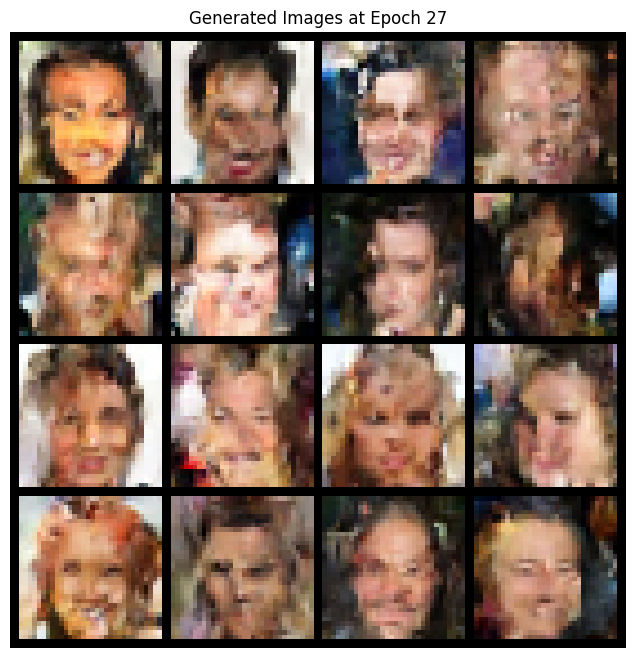

2025-06-23 00:02:58 - INFO - ------------------------------
2025-06-23 00:03:03 - INFO - Epoch: 28/60 | Batch: 0/318 | Loss (NLL): -8642.5176 | BPD: 3.9412
2025-06-23 00:05:26 - INFO - Epoch: 28/60 | Batch: 50/318 | Loss (NLL): -8662.9258 | BPD: 3.9317
2025-06-23 00:07:47 - INFO - Epoch: 28/60 | Batch: 100/318 | Loss (NLL): -8593.2168 | BPD: 3.9644
2025-06-23 00:10:09 - INFO - Epoch: 28/60 | Batch: 150/318 | Loss (NLL): -8454.1602 | BPD: 4.0297
2025-06-23 00:12:31 - INFO - Epoch: 28/60 | Batch: 200/318 | Loss (NLL): -8615.0840 | BPD: 3.9541
2025-06-23 00:14:53 - INFO - Epoch: 28/60 | Batch: 250/318 | Loss (NLL): -8619.8945 | BPD: 3.9519
2025-06-23 00:17:15 - INFO - Epoch: 28/60 | Batch: 300/318 | Loss (NLL): -8705.4023 | BPD: 3.9117
2025-06-23 00:18:04 - INFO - --- Epoch 28 Summary ---
2025-06-23 00:18:04 - INFO - Average Loss: -8662.0313 | Time: 905.90s
2025-06-23 00:18:04 - INFO - Generating sample images...


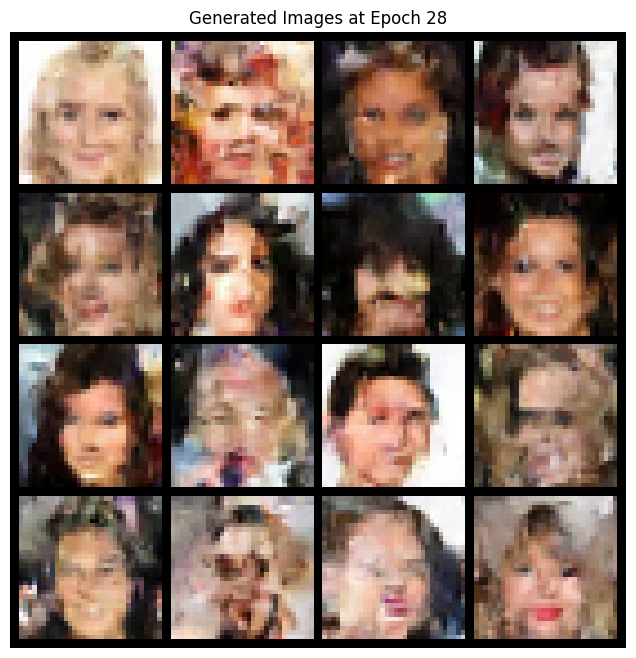

2025-06-23 00:18:04 - INFO - ------------------------------
2025-06-23 00:18:09 - INFO - Epoch: 29/60 | Batch: 0/318 | Loss (NLL): -8624.8105 | BPD: 3.9496
2025-06-23 00:20:31 - INFO - Epoch: 29/60 | Batch: 50/318 | Loss (NLL): -8645.4492 | BPD: 3.9399
2025-06-23 00:22:54 - INFO - Epoch: 29/60 | Batch: 100/318 | Loss (NLL): -8627.1836 | BPD: 3.9484
2025-06-23 00:25:16 - INFO - Epoch: 29/60 | Batch: 150/318 | Loss (NLL): -8671.7217 | BPD: 3.9275
2025-06-23 00:27:39 - INFO - Epoch: 29/60 | Batch: 200/318 | Loss (NLL): -8680.6094 | BPD: 3.9233
2025-06-23 00:30:01 - INFO - Epoch: 29/60 | Batch: 250/318 | Loss (NLL): -8690.5000 | BPD: 3.9187
2025-06-23 00:32:23 - INFO - Epoch: 29/60 | Batch: 300/318 | Loss (NLL): -8679.3906 | BPD: 3.9239
2025-06-23 00:33:11 - INFO - --- Epoch 29 Summary ---
2025-06-23 00:33:11 - INFO - Average Loss: -8675.6448 | Time: 906.75s
2025-06-23 00:33:11 - INFO - Generating sample images...


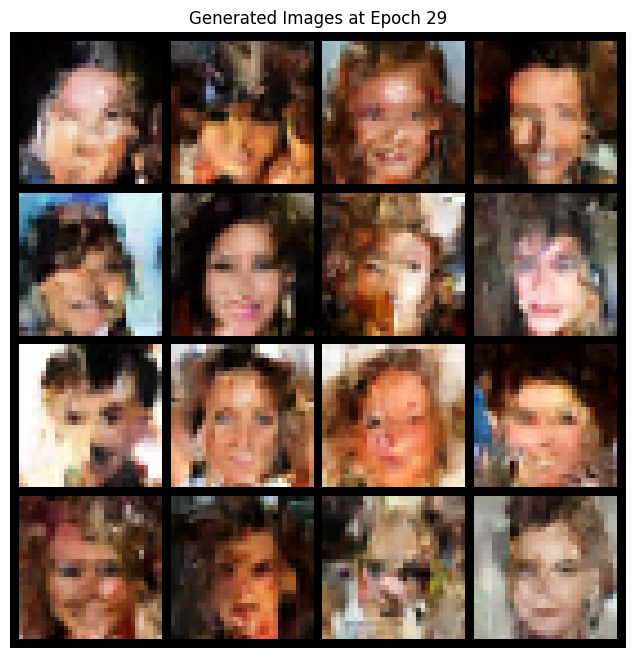

2025-06-23 00:33:12 - INFO - ------------------------------
2025-06-23 00:33:16 - INFO - Epoch: 30/60 | Batch: 0/318 | Loss (NLL): -8781.9482 | BPD: 3.8758
2025-06-23 00:35:38 - INFO - Epoch: 30/60 | Batch: 50/318 | Loss (NLL): -8631.2002 | BPD: 3.9466
2025-06-23 00:38:00 - INFO - Epoch: 30/60 | Batch: 100/318 | Loss (NLL): -8727.2090 | BPD: 3.9015
2025-06-23 00:40:22 - INFO - Epoch: 30/60 | Batch: 150/318 | Loss (NLL): -8747.3105 | BPD: 3.8920
2025-06-23 00:42:45 - INFO - Epoch: 30/60 | Batch: 200/318 | Loss (NLL): -8677.6914 | BPD: 3.9247
2025-06-23 00:45:07 - INFO - Epoch: 30/60 | Batch: 250/318 | Loss (NLL): -8811.8174 | BPD: 3.8617
2025-06-23 00:47:29 - INFO - Epoch: 30/60 | Batch: 300/318 | Loss (NLL): -8602.8535 | BPD: 3.9599
2025-06-23 00:48:18 - INFO - --- Epoch 30 Summary ---
2025-06-23 00:48:18 - INFO - Average Loss: -8686.7864 | Time: 906.13s
2025-06-23 00:48:18 - INFO - Generating sample images...


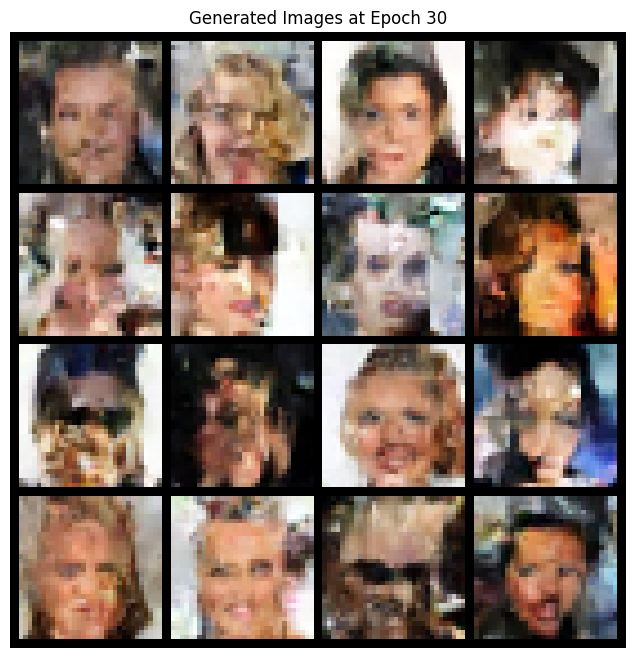

2025-06-23 00:48:18 - INFO - ------------------------------
2025-06-23 00:48:23 - INFO - Epoch: 31/60 | Batch: 0/318 | Loss (NLL): -8787.7900 | BPD: 3.8730
2025-06-23 00:50:45 - INFO - Epoch: 31/60 | Batch: 50/318 | Loss (NLL): -8706.0469 | BPD: 3.9114
2025-06-23 00:53:08 - INFO - Epoch: 31/60 | Batch: 100/318 | Loss (NLL): -8730.6680 | BPD: 3.8998
2025-06-23 00:55:30 - INFO - Epoch: 31/60 | Batch: 150/318 | Loss (NLL): -8668.7832 | BPD: 3.9289
2025-06-23 00:57:53 - INFO - Epoch: 31/60 | Batch: 200/318 | Loss (NLL): -8662.4727 | BPD: 3.9319
2025-06-23 01:00:20 - INFO - Epoch: 31/60 | Batch: 250/318 | Loss (NLL): -8763.7402 | BPD: 3.8843
2025-06-23 01:02:45 - INFO - Epoch: 31/60 | Batch: 300/318 | Loss (NLL): -8770.8047 | BPD: 3.8810
2025-06-23 01:03:35 - INFO - --- Epoch 31 Summary ---
2025-06-23 01:03:35 - INFO - Average Loss: -8716.9786 | Time: 916.72s
2025-06-23 01:03:35 - INFO - Generating sample images...


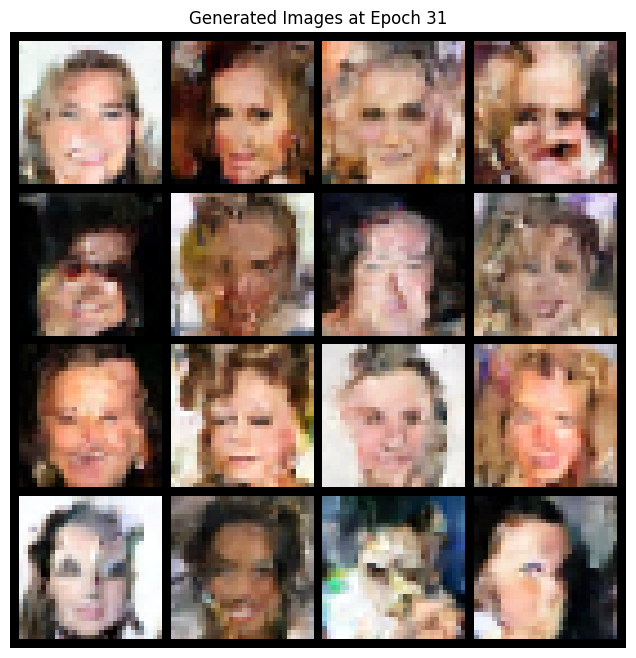

2025-06-23 01:03:35 - INFO - ------------------------------
2025-06-23 01:03:40 - INFO - Epoch: 32/60 | Batch: 0/318 | Loss (NLL): -8562.3535 | BPD: 3.9789
2025-06-23 01:06:07 - INFO - Epoch: 32/60 | Batch: 50/318 | Loss (NLL): -8795.9590 | BPD: 3.8692
2025-06-23 01:08:33 - INFO - Epoch: 32/60 | Batch: 100/318 | Loss (NLL): -8721.4434 | BPD: 3.9042
2025-06-23 01:10:59 - INFO - Epoch: 32/60 | Batch: 150/318 | Loss (NLL): -8688.3301 | BPD: 3.9197
2025-06-23 01:13:25 - INFO - Epoch: 32/60 | Batch: 200/318 | Loss (NLL): -8747.7031 | BPD: 3.8918
2025-06-23 01:15:51 - INFO - Epoch: 32/60 | Batch: 250/318 | Loss (NLL): -8809.8184 | BPD: 3.8627
2025-06-23 01:18:17 - INFO - Epoch: 32/60 | Batch: 300/318 | Loss (NLL): -8752.2617 | BPD: 3.8897
2025-06-23 01:19:07 - INFO - --- Epoch 32 Summary ---
2025-06-23 01:19:07 - INFO - Average Loss: -8716.8591 | Time: 931.16s
2025-06-23 01:19:07 - INFO - Generating sample images...


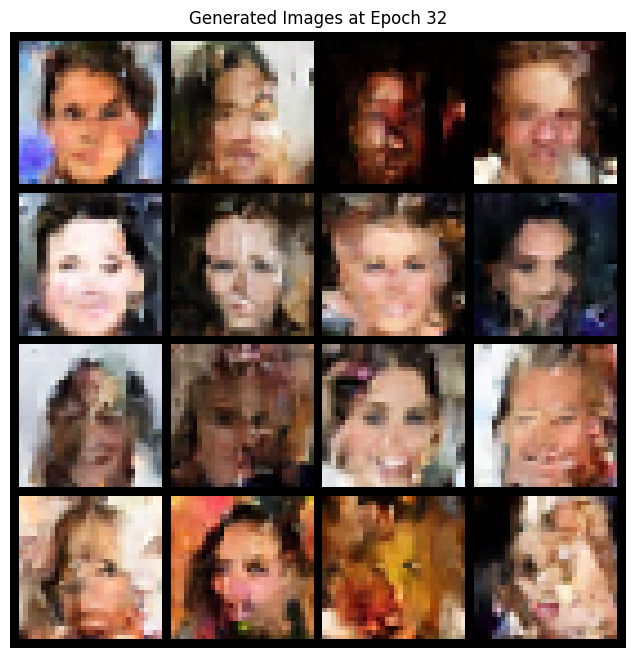

2025-06-23 01:19:07 - INFO - ------------------------------
2025-06-23 01:19:12 - INFO - Epoch: 33/60 | Batch: 0/318 | Loss (NLL): -8664.8691 | BPD: 3.9307
2025-06-23 01:21:38 - INFO - Epoch: 33/60 | Batch: 50/318 | Loss (NLL): -8613.7148 | BPD: 3.9548
2025-06-23 01:24:04 - INFO - Epoch: 33/60 | Batch: 100/318 | Loss (NLL): -8678.7432 | BPD: 3.9242
2025-06-23 01:26:30 - INFO - Epoch: 33/60 | Batch: 150/318 | Loss (NLL): -8701.9561 | BPD: 3.9133
2025-06-23 01:28:55 - INFO - Epoch: 33/60 | Batch: 200/318 | Loss (NLL): -8829.7520 | BPD: 3.8533
2025-06-23 01:31:20 - INFO - Epoch: 33/60 | Batch: 250/318 | Loss (NLL): -8648.9746 | BPD: 3.9382
2025-06-23 01:33:45 - INFO - Epoch: 33/60 | Batch: 300/318 | Loss (NLL): -8781.7764 | BPD: 3.8758
2025-06-23 01:34:33 - INFO - --- Epoch 33 Summary ---
2025-06-23 01:34:33 - INFO - Average Loss: -8716.9811 | Time: 925.74s
2025-06-23 01:34:33 - INFO - Generating sample images...


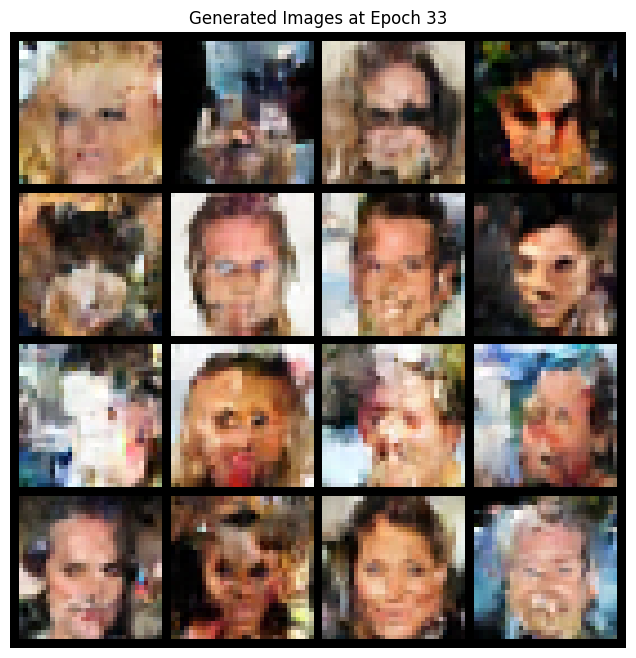

2025-06-23 01:34:33 - INFO - ------------------------------
2025-06-23 01:34:38 - INFO - Epoch: 34/60 | Batch: 0/318 | Loss (NLL): -8750.4375 | BPD: 3.8906
2025-06-23 01:37:00 - INFO - Epoch: 34/60 | Batch: 50/318 | Loss (NLL): -8767.4707 | BPD: 3.8826
2025-06-23 01:39:22 - INFO - Epoch: 34/60 | Batch: 100/318 | Loss (NLL): -8692.0449 | BPD: 3.9180
2025-06-23 01:41:44 - INFO - Epoch: 34/60 | Batch: 150/318 | Loss (NLL): -8704.0254 | BPD: 3.9124
2025-06-23 01:44:07 - INFO - Epoch: 34/60 | Batch: 200/318 | Loss (NLL): -8682.8203 | BPD: 3.9223
2025-06-23 01:46:29 - INFO - Epoch: 34/60 | Batch: 250/318 | Loss (NLL): -8793.8164 | BPD: 3.8702
2025-06-23 01:48:50 - INFO - Epoch: 34/60 | Batch: 300/318 | Loss (NLL): -8733.3604 | BPD: 3.8986
2025-06-23 01:49:38 - INFO - --- Epoch 34 Summary ---
2025-06-23 01:49:38 - INFO - Average Loss: -8722.6324 | Time: 904.74s
2025-06-23 01:49:38 - INFO - Generating sample images...


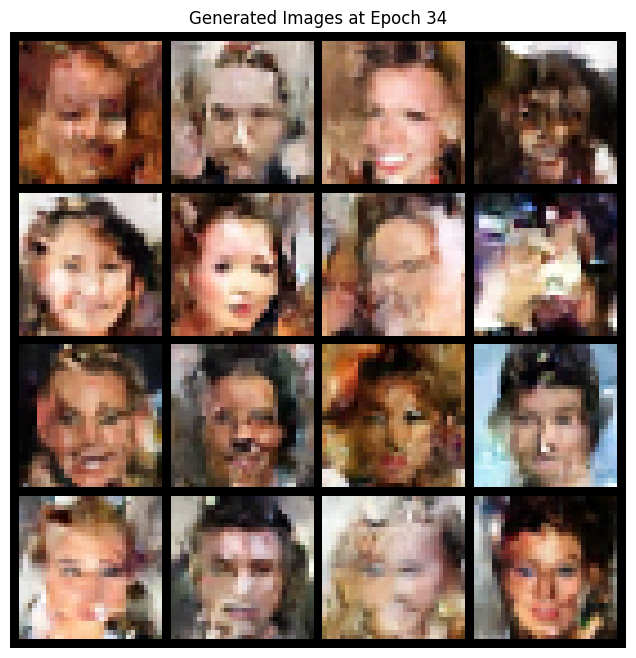

2025-06-23 01:49:39 - INFO - ------------------------------
2025-06-23 01:49:43 - INFO - Epoch: 35/60 | Batch: 0/318 | Loss (NLL): -8694.9941 | BPD: 3.9166
2025-06-23 01:52:05 - INFO - Epoch: 35/60 | Batch: 50/318 | Loss (NLL): -8754.5439 | BPD: 3.8886
2025-06-23 01:54:27 - INFO - Epoch: 35/60 | Batch: 100/318 | Loss (NLL): -8713.0156 | BPD: 3.9081
2025-06-23 01:56:50 - INFO - Epoch: 35/60 | Batch: 150/318 | Loss (NLL): -8741.7031 | BPD: 3.8947
2025-06-23 01:59:12 - INFO - Epoch: 35/60 | Batch: 200/318 | Loss (NLL): -8724.6836 | BPD: 3.9027
2025-06-23 02:01:36 - INFO - Epoch: 35/60 | Batch: 250/318 | Loss (NLL): -8754.0840 | BPD: 3.8888
2025-06-23 02:03:58 - INFO - Epoch: 35/60 | Batch: 300/318 | Loss (NLL): -8731.0898 | BPD: 3.8996
2025-06-23 02:04:46 - INFO - --- Epoch 35 Summary ---
2025-06-23 02:04:46 - INFO - Average Loss: -8746.3586 | Time: 907.29s
2025-06-23 02:04:46 - INFO - Generating sample images...


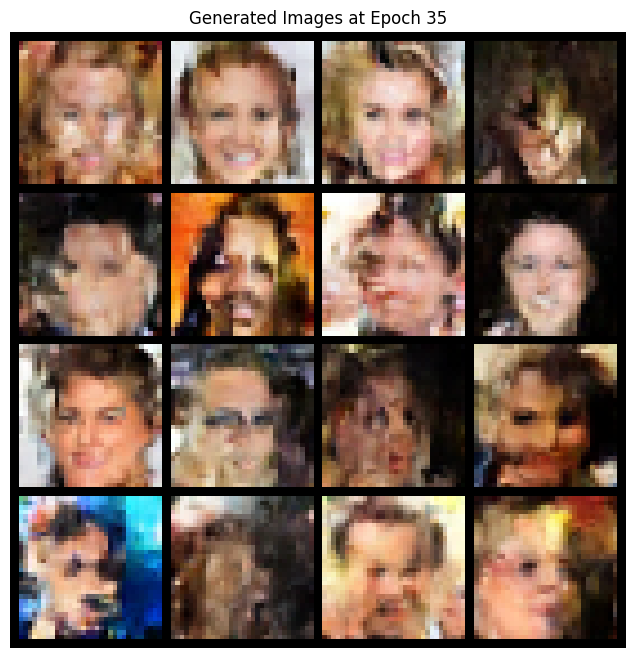

2025-06-23 02:04:47 - INFO - ------------------------------
2025-06-23 02:04:51 - INFO - Epoch: 36/60 | Batch: 0/318 | Loss (NLL): -8712.4980 | BPD: 3.9084
2025-06-23 02:07:13 - INFO - Epoch: 36/60 | Batch: 50/318 | Loss (NLL): -8814.5098 | BPD: 3.8605
2025-06-23 02:09:36 - INFO - Epoch: 36/60 | Batch: 100/318 | Loss (NLL): -8759.2441 | BPD: 3.8864
2025-06-23 02:11:59 - INFO - Epoch: 36/60 | Batch: 150/318 | Loss (NLL): -8791.1543 | BPD: 3.8714
2025-06-23 02:14:21 - INFO - Epoch: 36/60 | Batch: 200/318 | Loss (NLL): -8700.8828 | BPD: 3.9138
2025-06-23 02:16:42 - INFO - Epoch: 36/60 | Batch: 250/318 | Loss (NLL): -8737.4629 | BPD: 3.8966
2025-06-23 02:19:04 - INFO - Epoch: 36/60 | Batch: 300/318 | Loss (NLL): -8784.9717 | BPD: 3.8743
2025-06-23 02:19:52 - INFO - --- Epoch 36 Summary ---
2025-06-23 02:19:52 - INFO - Average Loss: -8752.6639 | Time: 905.56s
2025-06-23 02:19:52 - INFO - Generating sample images...


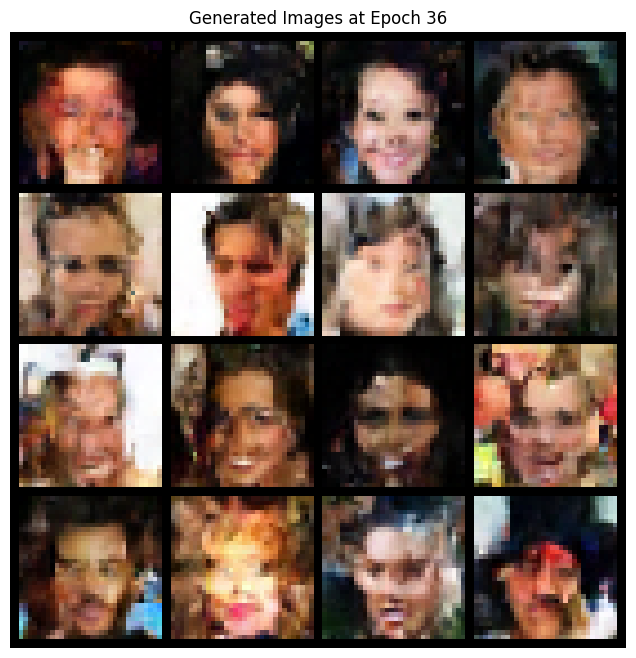

2025-06-23 02:19:53 - INFO - ------------------------------
2025-06-23 02:19:57 - INFO - Epoch: 37/60 | Batch: 0/318 | Loss (NLL): -8766.9570 | BPD: 3.8828
2025-06-23 02:22:20 - INFO - Epoch: 37/60 | Batch: 50/318 | Loss (NLL): -8859.8301 | BPD: 3.8392
2025-06-23 02:24:42 - INFO - Epoch: 37/60 | Batch: 100/318 | Loss (NLL): -8778.2227 | BPD: 3.8775
2025-06-23 02:27:05 - INFO - Epoch: 37/60 | Batch: 150/318 | Loss (NLL): -8711.0859 | BPD: 3.9090
2025-06-23 02:29:26 - INFO - Epoch: 37/60 | Batch: 200/318 | Loss (NLL): -8830.0078 | BPD: 3.8532
2025-06-23 02:31:48 - INFO - Epoch: 37/60 | Batch: 250/318 | Loss (NLL): -8805.4648 | BPD: 3.8647
2025-06-23 02:34:10 - INFO - Epoch: 37/60 | Batch: 300/318 | Loss (NLL): -8805.7832 | BPD: 3.8646
2025-06-23 02:34:58 - INFO - --- Epoch 37 Summary ---
2025-06-23 02:34:58 - INFO - Average Loss: -8765.8303 | Time: 905.31s
2025-06-23 02:34:58 - INFO - Generating sample images...


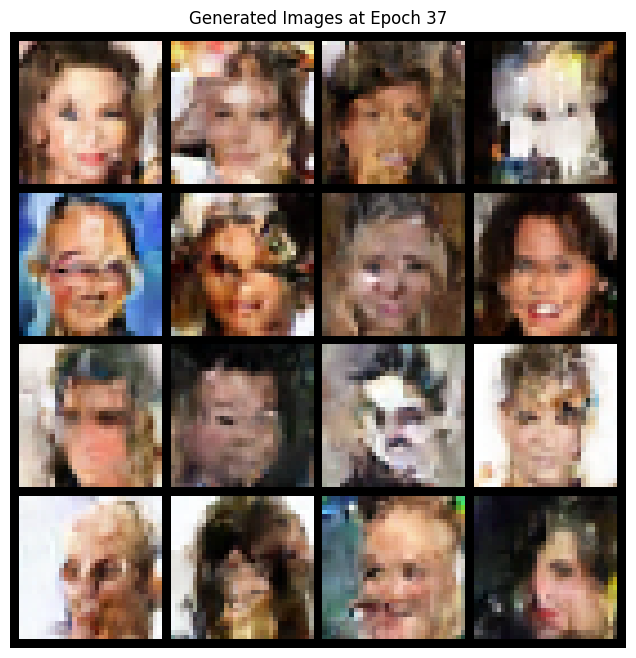

2025-06-23 02:34:59 - INFO - ------------------------------
2025-06-23 02:35:03 - INFO - Epoch: 38/60 | Batch: 0/318 | Loss (NLL): -8748.2109 | BPD: 3.8916
2025-06-23 02:37:25 - INFO - Epoch: 38/60 | Batch: 50/318 | Loss (NLL): -8859.5342 | BPD: 3.8393
2025-06-23 02:39:48 - INFO - Epoch: 38/60 | Batch: 100/318 | Loss (NLL): -8768.8828 | BPD: 3.8819
2025-06-23 02:42:10 - INFO - Epoch: 38/60 | Batch: 150/318 | Loss (NLL): -8721.0498 | BPD: 3.9044
2025-06-23 02:44:32 - INFO - Epoch: 38/60 | Batch: 200/318 | Loss (NLL): -8747.0332 | BPD: 3.8922
2025-06-23 02:46:55 - INFO - Epoch: 38/60 | Batch: 250/318 | Loss (NLL): -8840.7070 | BPD: 3.8482
2025-06-23 02:49:17 - INFO - Epoch: 38/60 | Batch: 300/318 | Loss (NLL): -8763.4453 | BPD: 3.8844
2025-06-23 02:50:05 - INFO - --- Epoch 38 Summary ---
2025-06-23 02:50:05 - INFO - Average Loss: -8789.5867 | Time: 906.73s
2025-06-23 02:50:05 - INFO - Generating sample images...


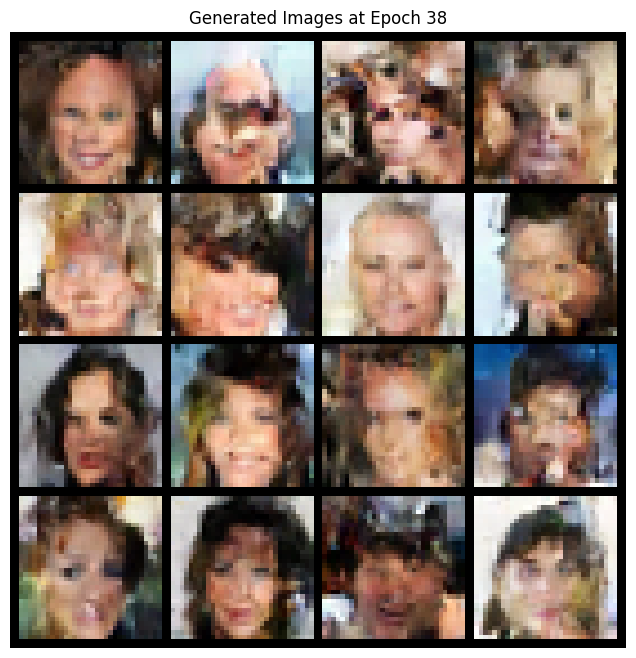

2025-06-23 02:50:06 - INFO - ------------------------------
2025-06-23 02:50:10 - INFO - Epoch: 39/60 | Batch: 0/318 | Loss (NLL): -8693.3105 | BPD: 3.9174
2025-06-23 02:52:33 - INFO - Epoch: 39/60 | Batch: 50/318 | Loss (NLL): -8806.0586 | BPD: 3.8644
2025-06-23 02:54:55 - INFO - Epoch: 39/60 | Batch: 100/318 | Loss (NLL): -8840.6338 | BPD: 3.8482
2025-06-23 02:57:17 - INFO - Epoch: 39/60 | Batch: 150/318 | Loss (NLL): -8794.4980 | BPD: 3.8699
2025-06-23 02:59:39 - INFO - Epoch: 39/60 | Batch: 200/318 | Loss (NLL): -8796.1660 | BPD: 3.8691
2025-06-23 03:02:01 - INFO - Epoch: 39/60 | Batch: 250/318 | Loss (NLL): -8716.0381 | BPD: 3.9067
2025-06-23 03:04:24 - INFO - Epoch: 39/60 | Batch: 300/318 | Loss (NLL): -8778.3867 | BPD: 3.8774
2025-06-23 03:05:12 - INFO - --- Epoch 39 Summary ---
2025-06-23 03:05:12 - INFO - Average Loss: -8792.7508 | Time: 906.20s
2025-06-23 03:05:12 - INFO - Generating sample images...


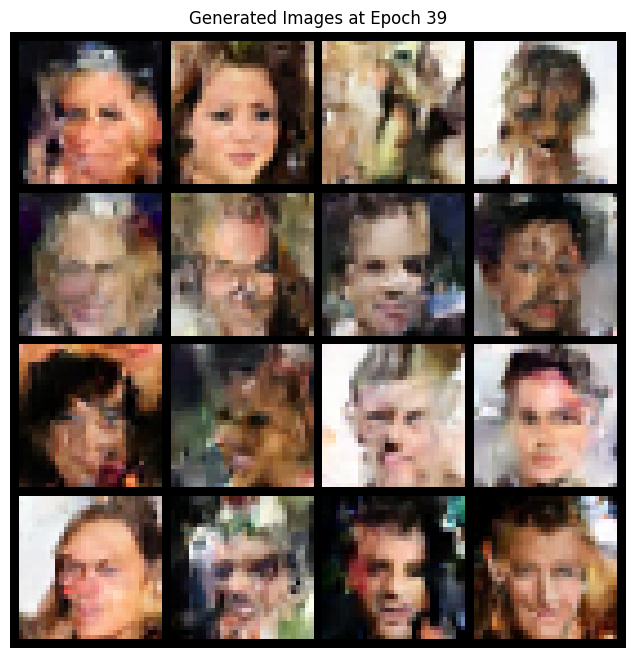

2025-06-23 03:05:12 - INFO - ------------------------------
2025-06-23 03:05:17 - INFO - Epoch: 40/60 | Batch: 0/318 | Loss (NLL): -8814.0957 | BPD: 3.8607
2025-06-23 03:07:39 - INFO - Epoch: 40/60 | Batch: 50/318 | Loss (NLL): -8808.8652 | BPD: 3.8631
2025-06-23 03:10:02 - INFO - Epoch: 40/60 | Batch: 100/318 | Loss (NLL): -8772.1729 | BPD: 3.8803
2025-06-23 03:12:24 - INFO - Epoch: 40/60 | Batch: 150/318 | Loss (NLL): -8791.6777 | BPD: 3.8712
2025-06-23 03:14:46 - INFO - Epoch: 40/60 | Batch: 200/318 | Loss (NLL): -8744.7598 | BPD: 3.8932
2025-06-23 03:17:08 - INFO - Epoch: 40/60 | Batch: 250/318 | Loss (NLL): -8782.4707 | BPD: 3.8755
2025-06-23 03:19:31 - INFO - Epoch: 40/60 | Batch: 300/318 | Loss (NLL): -8855.2871 | BPD: 3.8413
2025-06-23 03:20:19 - INFO - --- Epoch 40 Summary ---
2025-06-23 03:20:19 - INFO - Average Loss: -8798.1295 | Time: 906.07s
2025-06-23 03:20:19 - INFO - Generating sample images...


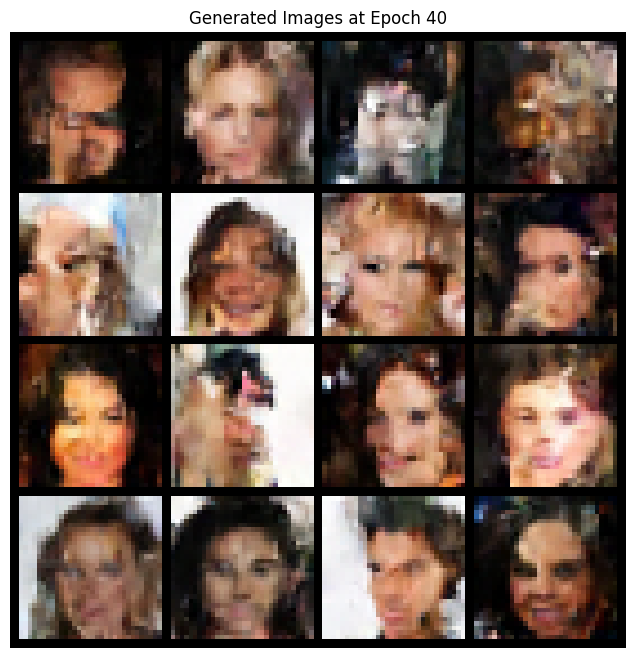

2025-06-23 03:20:19 - INFO - ------------------------------
2025-06-23 03:20:24 - INFO - Epoch: 41/60 | Batch: 0/318 | Loss (NLL): -8818.9395 | BPD: 3.8584
2025-06-23 03:22:46 - INFO - Epoch: 41/60 | Batch: 50/318 | Loss (NLL): -8769.0957 | BPD: 3.8818
2025-06-23 03:25:08 - INFO - Epoch: 41/60 | Batch: 100/318 | Loss (NLL): -8849.6387 | BPD: 3.8440
2025-06-23 03:27:30 - INFO - Epoch: 41/60 | Batch: 150/318 | Loss (NLL): -8837.0273 | BPD: 3.8499
2025-06-23 03:29:53 - INFO - Epoch: 41/60 | Batch: 200/318 | Loss (NLL): -8861.0117 | BPD: 3.8386
2025-06-23 03:32:15 - INFO - Epoch: 41/60 | Batch: 250/318 | Loss (NLL): -8854.4082 | BPD: 3.8417
2025-06-23 03:34:38 - INFO - Epoch: 41/60 | Batch: 300/318 | Loss (NLL): -8761.1084 | BPD: 3.8855
2025-06-23 03:35:27 - INFO - --- Epoch 41 Summary ---
2025-06-23 03:35:27 - INFO - Average Loss: -8805.0735 | Time: 908.16s
2025-06-23 03:35:27 - INFO - Generating sample images...


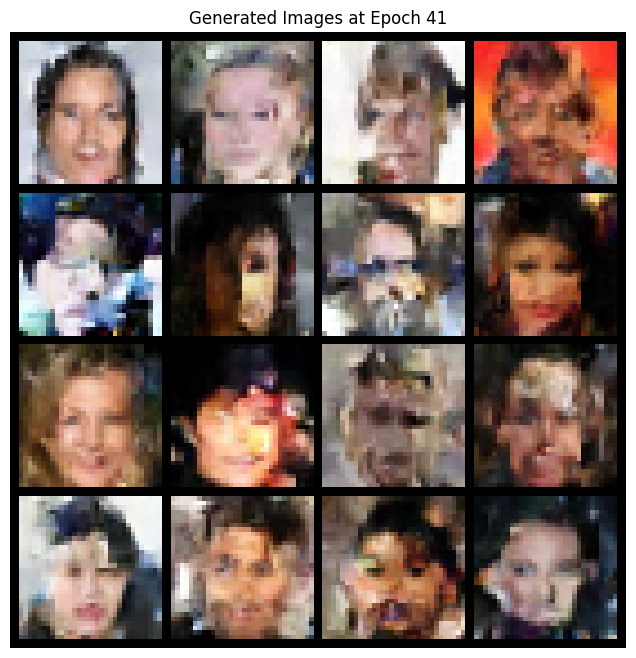

2025-06-23 03:35:28 - INFO - ------------------------------
2025-06-23 03:35:32 - INFO - Epoch: 42/60 | Batch: 0/318 | Loss (NLL): -8826.5664 | BPD: 3.8548
2025-06-23 03:37:56 - INFO - Epoch: 42/60 | Batch: 50/318 | Loss (NLL): -8783.7852 | BPD: 3.8749
2025-06-23 03:40:19 - INFO - Epoch: 42/60 | Batch: 100/318 | Loss (NLL): -8880.6670 | BPD: 3.8294
2025-06-23 03:42:41 - INFO - Epoch: 42/60 | Batch: 150/318 | Loss (NLL): -8870.5312 | BPD: 3.8342
2025-06-23 03:45:03 - INFO - Epoch: 42/60 | Batch: 200/318 | Loss (NLL): -8811.0127 | BPD: 3.8621
2025-06-23 03:47:26 - INFO - Epoch: 42/60 | Batch: 250/318 | Loss (NLL): -8816.3994 | BPD: 3.8596
2025-06-23 03:49:49 - INFO - Epoch: 42/60 | Batch: 300/318 | Loss (NLL): -8782.9434 | BPD: 3.8753
2025-06-23 03:50:38 - INFO - --- Epoch 42 Summary ---
2025-06-23 03:50:38 - INFO - Average Loss: -8825.2845 | Time: 909.76s
2025-06-23 03:50:38 - INFO - Generating sample images...


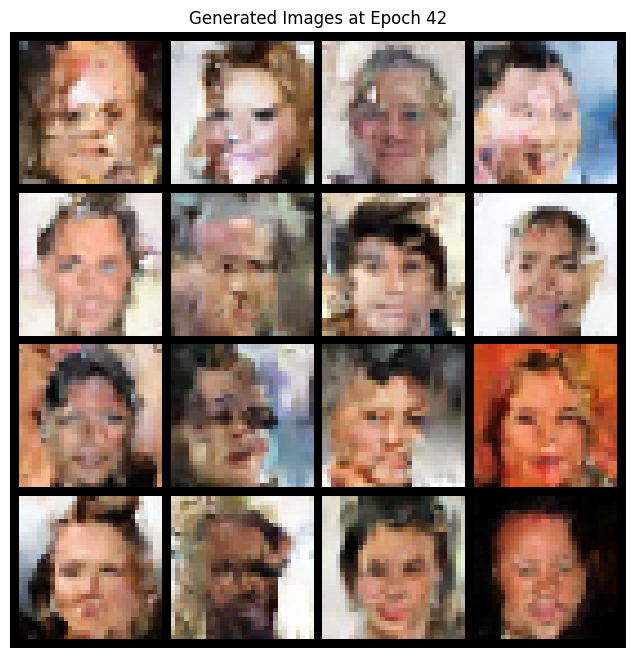

2025-06-23 03:50:38 - INFO - ------------------------------
2025-06-23 03:50:43 - INFO - Epoch: 43/60 | Batch: 0/318 | Loss (NLL): -8847.2480 | BPD: 3.8451
2025-06-23 03:53:06 - INFO - Epoch: 43/60 | Batch: 50/318 | Loss (NLL): -8887.4551 | BPD: 3.8262
2025-06-23 03:55:29 - INFO - Epoch: 43/60 | Batch: 100/318 | Loss (NLL): -8803.9961 | BPD: 3.8654
2025-06-23 03:57:53 - INFO - Epoch: 43/60 | Batch: 150/318 | Loss (NLL): -8816.5410 | BPD: 3.8595
2025-06-23 04:00:15 - INFO - Epoch: 43/60 | Batch: 200/318 | Loss (NLL): -8811.4424 | BPD: 3.8619
2025-06-23 04:02:38 - INFO - Epoch: 43/60 | Batch: 250/318 | Loss (NLL): -8868.2695 | BPD: 3.8352
2025-06-23 04:05:01 - INFO - Epoch: 43/60 | Batch: 300/318 | Loss (NLL): -8830.0449 | BPD: 3.8532
2025-06-23 04:05:49 - INFO - --- Epoch 43 Summary ---
2025-06-23 04:05:49 - INFO - Average Loss: -8824.4176 | Time: 910.84s
2025-06-23 04:05:49 - INFO - Generating sample images...


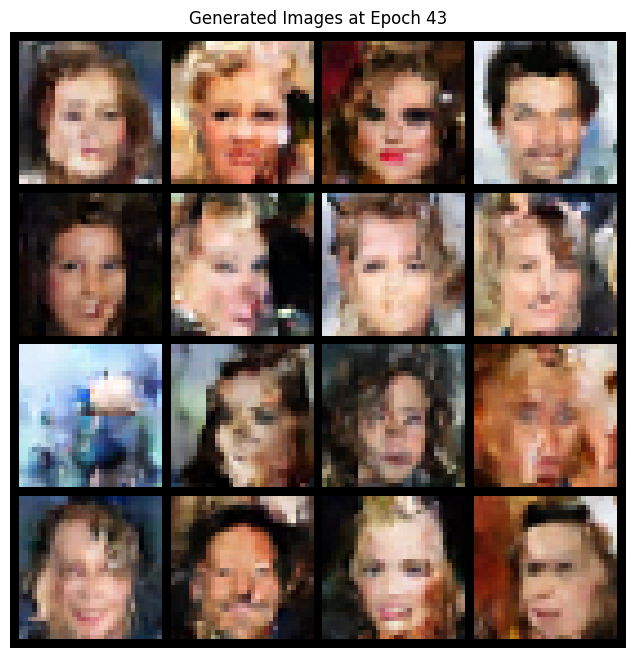

2025-06-23 04:05:49 - INFO - ------------------------------
2025-06-23 04:05:54 - INFO - Epoch: 44/60 | Batch: 0/318 | Loss (NLL): -8797.8887 | BPD: 3.8683
2025-06-23 04:08:17 - INFO - Epoch: 44/60 | Batch: 50/318 | Loss (NLL): -8831.0918 | BPD: 3.8527
2025-06-23 04:10:39 - INFO - Epoch: 44/60 | Batch: 100/318 | Loss (NLL): -8859.5000 | BPD: 3.8393
2025-06-23 04:13:02 - INFO - Epoch: 44/60 | Batch: 150/318 | Loss (NLL): -8935.3027 | BPD: 3.8037
2025-06-23 04:15:25 - INFO - Epoch: 44/60 | Batch: 200/318 | Loss (NLL): -8800.0508 | BPD: 3.8673
2025-06-23 04:17:47 - INFO - Epoch: 44/60 | Batch: 250/318 | Loss (NLL): -8782.5830 | BPD: 3.8755
2025-06-23 04:20:09 - INFO - Epoch: 44/60 | Batch: 300/318 | Loss (NLL): -8882.2744 | BPD: 3.8286
2025-06-23 04:20:57 - INFO - --- Epoch 44 Summary ---
2025-06-23 04:20:57 - INFO - Average Loss: -8839.2307 | Time: 907.52s
2025-06-23 04:20:57 - INFO - Generating sample images...


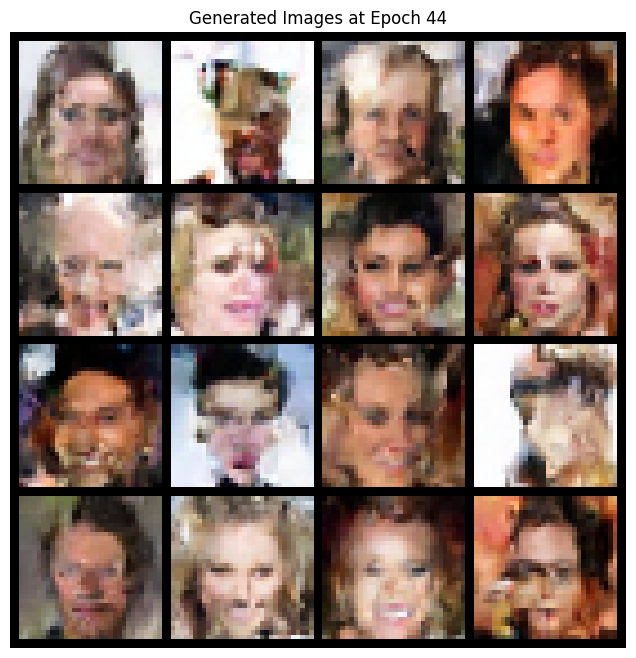

2025-06-23 04:20:58 - INFO - ------------------------------
2025-06-23 04:21:02 - INFO - Epoch: 45/60 | Batch: 0/318 | Loss (NLL): -8858.9541 | BPD: 3.8396
2025-06-23 04:23:24 - INFO - Epoch: 45/60 | Batch: 50/318 | Loss (NLL): -8795.4004 | BPD: 3.8694
2025-06-23 04:25:47 - INFO - Epoch: 45/60 | Batch: 100/318 | Loss (NLL): -8808.2949 | BPD: 3.8634
2025-06-23 04:28:09 - INFO - Epoch: 45/60 | Batch: 150/318 | Loss (NLL): -8797.3477 | BPD: 3.8685
2025-06-23 04:30:32 - INFO - Epoch: 45/60 | Batch: 200/318 | Loss (NLL): -8850.5742 | BPD: 3.8435
2025-06-23 04:32:54 - INFO - Epoch: 45/60 | Batch: 250/318 | Loss (NLL): -8803.6455 | BPD: 3.8656
2025-06-23 04:35:16 - INFO - Epoch: 45/60 | Batch: 300/318 | Loss (NLL): -8849.4424 | BPD: 3.8441
2025-06-23 04:36:05 - INFO - --- Epoch 45 Summary ---
2025-06-23 04:36:05 - INFO - Average Loss: -8852.0145 | Time: 907.14s
2025-06-23 04:36:05 - INFO - Generating sample images...


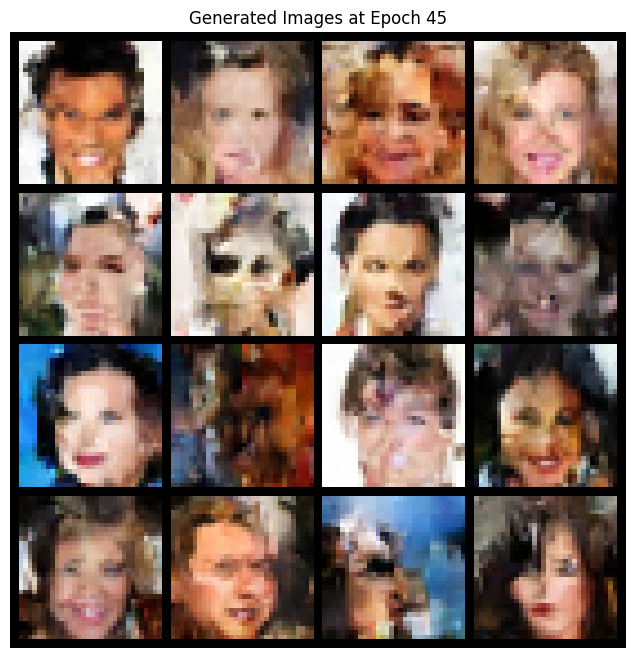

2025-06-23 04:36:05 - INFO - ------------------------------
2025-06-23 04:36:10 - INFO - Epoch: 46/60 | Batch: 0/318 | Loss (NLL): -8876.0977 | BPD: 3.8315
2025-06-23 04:38:32 - INFO - Epoch: 46/60 | Batch: 50/318 | Loss (NLL): -8940.5361 | BPD: 3.8013
2025-06-23 04:40:55 - INFO - Epoch: 46/60 | Batch: 100/318 | Loss (NLL): -8864.6035 | BPD: 3.8369
2025-06-23 04:43:18 - INFO - Epoch: 46/60 | Batch: 150/318 | Loss (NLL): -8881.5586 | BPD: 3.8290
2025-06-23 04:45:40 - INFO - Epoch: 46/60 | Batch: 200/318 | Loss (NLL): -8884.8086 | BPD: 3.8275
2025-06-23 04:48:03 - INFO - Epoch: 46/60 | Batch: 250/318 | Loss (NLL): -8774.9287 | BPD: 3.8791
2025-06-23 04:50:26 - INFO - Epoch: 46/60 | Batch: 300/318 | Loss (NLL): -8808.6562 | BPD: 3.8632
2025-06-23 04:51:15 - INFO - --- Epoch 46 Summary ---
2025-06-23 04:51:15 - INFO - Average Loss: -8834.7647 | Time: 909.50s
2025-06-23 04:51:15 - INFO - Generating sample images...


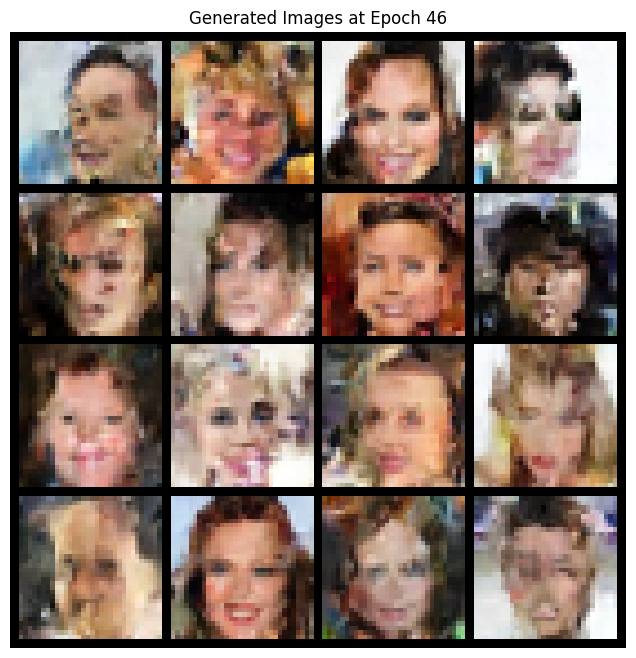

2025-06-23 04:51:15 - INFO - ------------------------------
2025-06-23 04:51:20 - INFO - Epoch: 47/60 | Batch: 0/318 | Loss (NLL): -8901.9209 | BPD: 3.8194
2025-06-23 04:53:43 - INFO - Epoch: 47/60 | Batch: 50/318 | Loss (NLL): -8885.4014 | BPD: 3.8272
2025-06-23 04:56:05 - INFO - Epoch: 47/60 | Batch: 100/318 | Loss (NLL): -8739.5059 | BPD: 3.8957
2025-06-23 04:58:29 - INFO - Epoch: 47/60 | Batch: 150/318 | Loss (NLL): -8917.0449 | BPD: 3.8123
2025-06-23 05:00:52 - INFO - Epoch: 47/60 | Batch: 200/318 | Loss (NLL): -8768.6016 | BPD: 3.8820
2025-06-23 05:03:14 - INFO - Epoch: 47/60 | Batch: 250/318 | Loss (NLL): -8893.2705 | BPD: 3.8235
2025-06-23 05:05:36 - INFO - Epoch: 47/60 | Batch: 300/318 | Loss (NLL): -8840.9180 | BPD: 3.8481
2025-06-23 05:06:24 - INFO - --- Epoch 47 Summary ---
2025-06-23 05:06:24 - INFO - Average Loss: -8852.8779 | Time: 909.07s
2025-06-23 05:06:24 - INFO - Generating sample images...


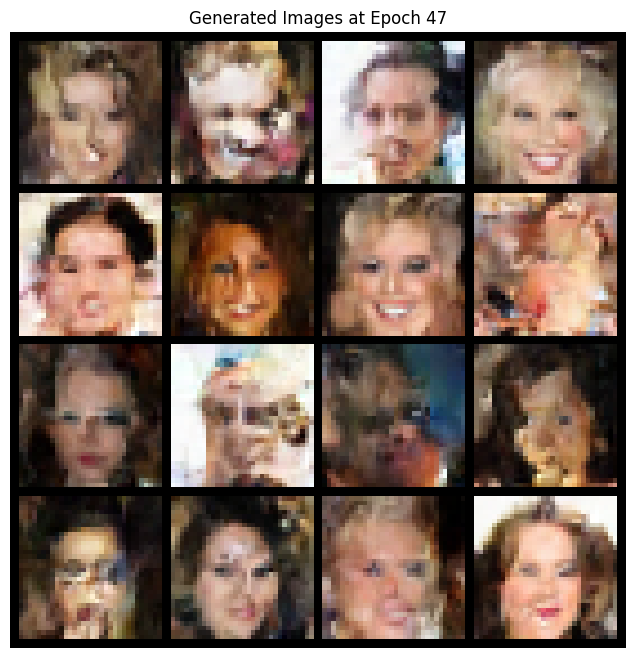

2025-06-23 05:06:25 - INFO - ------------------------------
2025-06-23 05:06:29 - INFO - Epoch: 48/60 | Batch: 0/318 | Loss (NLL): -8895.0977 | BPD: 3.8226
2025-06-23 05:08:53 - INFO - Epoch: 48/60 | Batch: 50/318 | Loss (NLL): -8853.4316 | BPD: 3.8422
2025-06-23 05:11:18 - INFO - Epoch: 48/60 | Batch: 100/318 | Loss (NLL): -8870.3555 | BPD: 3.8342
2025-06-23 05:13:42 - INFO - Epoch: 48/60 | Batch: 150/318 | Loss (NLL): -8864.2100 | BPD: 3.8371
2025-06-23 05:16:04 - INFO - Epoch: 48/60 | Batch: 200/318 | Loss (NLL): -8872.1982 | BPD: 3.8334
2025-06-23 05:18:26 - INFO - Epoch: 48/60 | Batch: 250/318 | Loss (NLL): -8905.6885 | BPD: 3.8176
2025-06-23 05:20:48 - INFO - Epoch: 48/60 | Batch: 300/318 | Loss (NLL): -8899.4668 | BPD: 3.8206
2025-06-23 05:21:36 - INFO - --- Epoch 48 Summary ---
2025-06-23 05:21:36 - INFO - Average Loss: -8858.4515 | Time: 911.39s
2025-06-23 05:21:36 - INFO - Generating sample images...


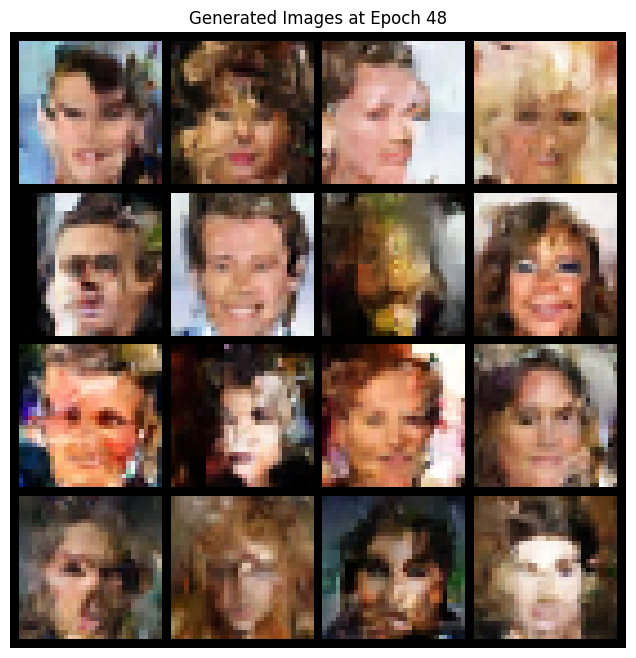

2025-06-23 05:21:37 - INFO - ------------------------------
2025-06-23 05:21:41 - INFO - Epoch: 49/60 | Batch: 0/318 | Loss (NLL): -8797.9336 | BPD: 3.8683
2025-06-23 05:24:03 - INFO - Epoch: 49/60 | Batch: 50/318 | Loss (NLL): -8873.1660 | BPD: 3.8329
2025-06-23 05:26:26 - INFO - Epoch: 49/60 | Batch: 100/318 | Loss (NLL): -8904.4863 | BPD: 3.8182
2025-06-23 05:28:48 - INFO - Epoch: 49/60 | Batch: 150/318 | Loss (NLL): -8906.0439 | BPD: 3.8175
2025-06-23 05:31:10 - INFO - Epoch: 49/60 | Batch: 200/318 | Loss (NLL): -8910.3535 | BPD: 3.8155
2025-06-23 05:33:32 - INFO - Epoch: 49/60 | Batch: 250/318 | Loss (NLL): -8866.3203 | BPD: 3.8361
2025-06-23 05:35:55 - INFO - Epoch: 49/60 | Batch: 300/318 | Loss (NLL): -8861.4336 | BPD: 3.8384
2025-06-23 05:36:43 - INFO - --- Epoch 49 Summary ---
2025-06-23 05:36:43 - INFO - Average Loss: -8876.6614 | Time: 906.01s
2025-06-23 05:36:43 - INFO - Generating sample images...


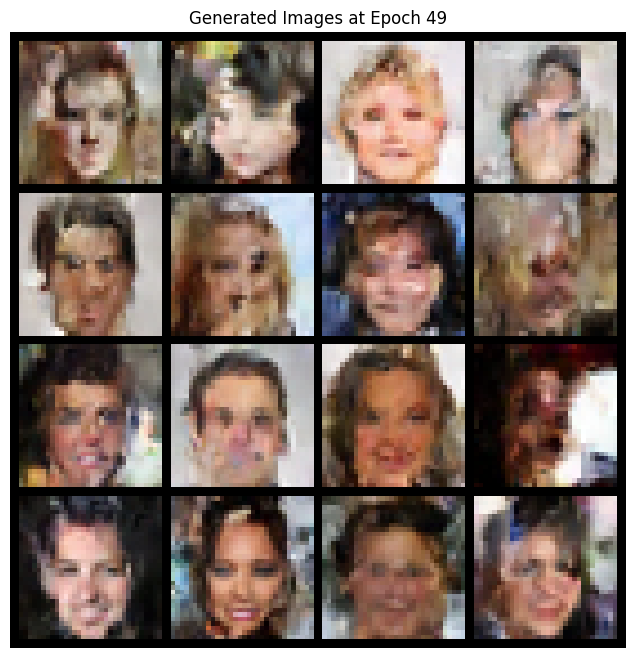

2025-06-23 05:36:43 - INFO - ------------------------------
2025-06-23 05:36:48 - INFO - Epoch: 50/60 | Batch: 0/318 | Loss (NLL): -8778.9961 | BPD: 3.8771
2025-06-23 05:39:11 - INFO - Epoch: 50/60 | Batch: 50/318 | Loss (NLL): -8895.6113 | BPD: 3.8224
2025-06-23 05:41:35 - INFO - Epoch: 50/60 | Batch: 100/318 | Loss (NLL): -8895.6729 | BPD: 3.8223
2025-06-23 05:44:00 - INFO - Epoch: 50/60 | Batch: 150/318 | Loss (NLL): -8752.0059 | BPD: 3.8898
2025-06-23 05:46:24 - INFO - Epoch: 50/60 | Batch: 200/318 | Loss (NLL): -8802.7744 | BPD: 3.8660
2025-06-23 05:48:48 - INFO - Epoch: 50/60 | Batch: 250/318 | Loss (NLL): -8846.1074 | BPD: 3.8456
2025-06-23 05:51:12 - INFO - Epoch: 50/60 | Batch: 300/318 | Loss (NLL): -8846.6172 | BPD: 3.8454
2025-06-23 05:52:01 - INFO - --- Epoch 50 Summary ---
2025-06-23 05:52:01 - INFO - Average Loss: -8872.0103 | Time: 918.15s
2025-06-23 05:52:01 - INFO - Generating sample images...


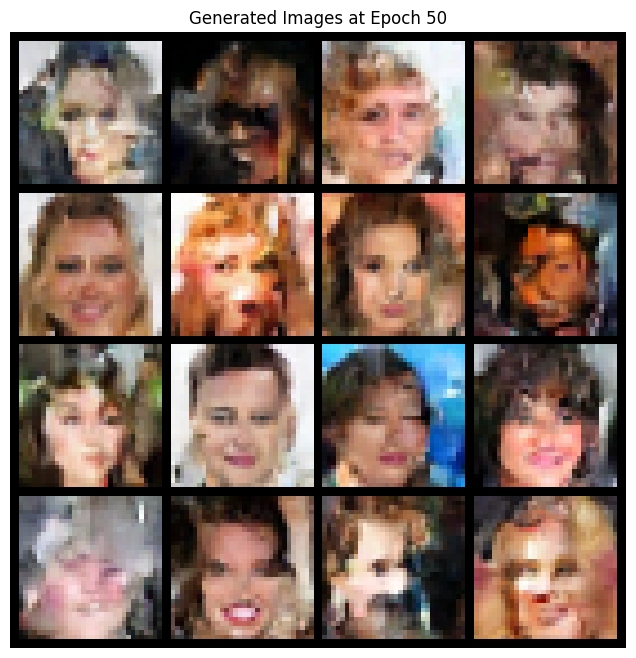

2025-06-23 05:52:02 - INFO - ------------------------------
2025-06-23 05:52:07 - INFO - Epoch: 51/60 | Batch: 0/318 | Loss (NLL): -8933.1250 | BPD: 3.8048
2025-06-23 05:54:32 - INFO - Epoch: 51/60 | Batch: 50/318 | Loss (NLL): -8903.9365 | BPD: 3.8185
2025-06-23 05:56:56 - INFO - Epoch: 51/60 | Batch: 100/318 | Loss (NLL): -8923.8057 | BPD: 3.8091
2025-06-23 05:59:21 - INFO - Epoch: 51/60 | Batch: 150/318 | Loss (NLL): -8991.9023 | BPD: 3.7772
2025-06-23 06:01:45 - INFO - Epoch: 51/60 | Batch: 200/318 | Loss (NLL): -8880.1875 | BPD: 3.8296
2025-06-23 06:04:08 - INFO - Epoch: 51/60 | Batch: 250/318 | Loss (NLL): -8800.6943 | BPD: 3.8670
2025-06-23 06:06:30 - INFO - Epoch: 51/60 | Batch: 300/318 | Loss (NLL): -8978.3926 | BPD: 3.7835
2025-06-23 06:07:19 - INFO - --- Epoch 51 Summary ---
2025-06-23 06:07:19 - INFO - Average Loss: -8894.5797 | Time: 916.89s
2025-06-23 06:07:19 - INFO - Generating sample images...


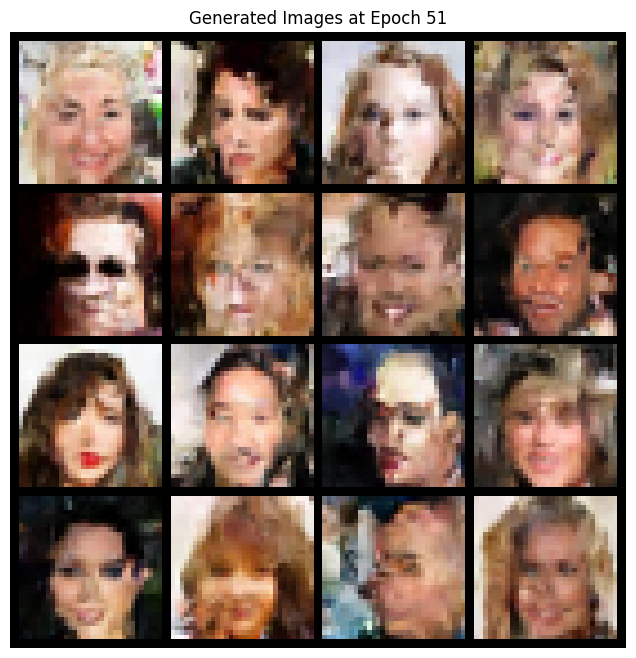

2025-06-23 06:07:19 - INFO - ------------------------------
2025-06-23 06:07:24 - INFO - Epoch: 52/60 | Batch: 0/318 | Loss (NLL): -8891.5234 | BPD: 3.8243
2025-06-23 06:09:47 - INFO - Epoch: 52/60 | Batch: 50/318 | Loss (NLL): -8833.5762 | BPD: 3.8515
2025-06-23 06:12:10 - INFO - Epoch: 52/60 | Batch: 100/318 | Loss (NLL): -8827.7305 | BPD: 3.8543
2025-06-23 06:14:33 - INFO - Epoch: 52/60 | Batch: 150/318 | Loss (NLL): -8887.5400 | BPD: 3.8262
2025-06-23 06:16:56 - INFO - Epoch: 52/60 | Batch: 200/318 | Loss (NLL): -8942.0469 | BPD: 3.8006
2025-06-23 06:19:19 - INFO - Epoch: 52/60 | Batch: 250/318 | Loss (NLL): -8894.2041 | BPD: 3.8230
2025-06-23 06:21:41 - INFO - Epoch: 52/60 | Batch: 300/318 | Loss (NLL): -8893.2627 | BPD: 3.8235
2025-06-23 06:22:30 - INFO - --- Epoch 52 Summary ---
2025-06-23 06:22:30 - INFO - Average Loss: -8872.9685 | Time: 910.55s
2025-06-23 06:22:30 - INFO - Generating sample images...


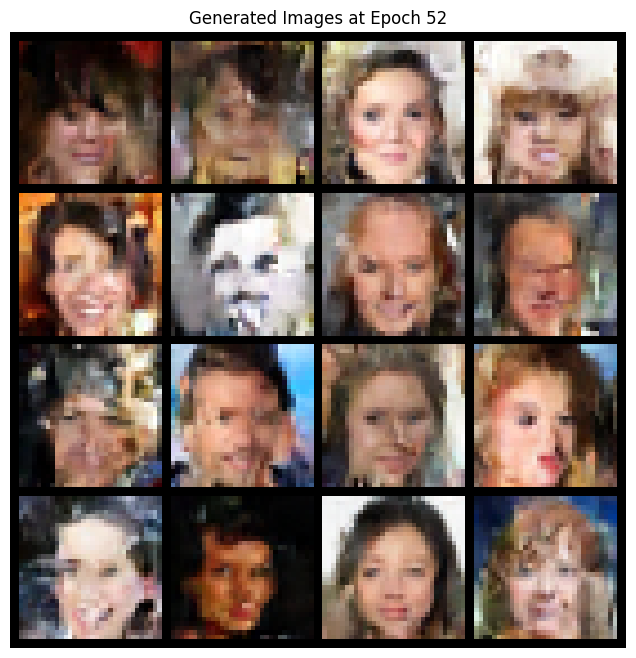

2025-06-23 06:22:30 - INFO - ------------------------------
2025-06-23 06:22:35 - INFO - Epoch: 53/60 | Batch: 0/318 | Loss (NLL): -8952.0039 | BPD: 3.7959
2025-06-23 06:24:58 - INFO - Epoch: 53/60 | Batch: 50/318 | Loss (NLL): -8877.7100 | BPD: 3.8308
2025-06-23 06:27:20 - INFO - Epoch: 53/60 | Batch: 100/318 | Loss (NLL): -8886.6602 | BPD: 3.8266
2025-06-23 06:29:43 - INFO - Epoch: 53/60 | Batch: 150/318 | Loss (NLL): -8837.7910 | BPD: 3.8495
2025-06-23 06:32:06 - INFO - Epoch: 53/60 | Batch: 200/318 | Loss (NLL): -8837.5088 | BPD: 3.8497
2025-06-23 06:34:29 - INFO - Epoch: 53/60 | Batch: 250/318 | Loss (NLL): -8875.0371 | BPD: 3.8320
2025-06-23 06:36:51 - INFO - Epoch: 53/60 | Batch: 300/318 | Loss (NLL): -8988.3994 | BPD: 3.7788
2025-06-23 06:37:40 - INFO - --- Epoch 53 Summary ---
2025-06-23 06:37:40 - INFO - Average Loss: -8895.7975 | Time: 909.42s
2025-06-23 06:37:40 - INFO - Generating sample images...


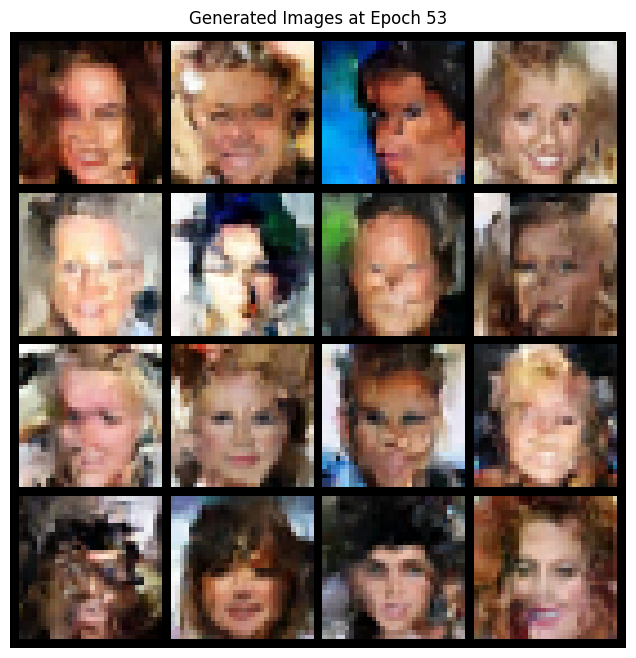

2025-06-23 06:37:40 - INFO - ------------------------------
2025-06-23 06:37:45 - INFO - Epoch: 54/60 | Batch: 0/318 | Loss (NLL): -8857.1973 | BPD: 3.8404
2025-06-23 06:40:08 - INFO - Epoch: 54/60 | Batch: 50/318 | Loss (NLL): -8850.9023 | BPD: 3.8434
2025-06-23 06:42:31 - INFO - Epoch: 54/60 | Batch: 100/318 | Loss (NLL): -8946.8750 | BPD: 3.7983
2025-06-23 06:44:53 - INFO - Epoch: 54/60 | Batch: 150/318 | Loss (NLL): -8936.2676 | BPD: 3.8033
2025-06-23 06:47:18 - INFO - Epoch: 54/60 | Batch: 200/318 | Loss (NLL): -8848.5723 | BPD: 3.8445
2025-06-23 06:49:42 - INFO - Epoch: 54/60 | Batch: 250/318 | Loss (NLL): -8913.2598 | BPD: 3.8141
2025-06-23 06:52:04 - INFO - Epoch: 54/60 | Batch: 300/318 | Loss (NLL): -8901.3730 | BPD: 3.8197
2025-06-23 06:52:52 - INFO - --- Epoch 54 Summary ---
2025-06-23 06:52:52 - INFO - Average Loss: -8904.1372 | Time: 911.51s
2025-06-23 06:52:52 - INFO - Generating sample images...


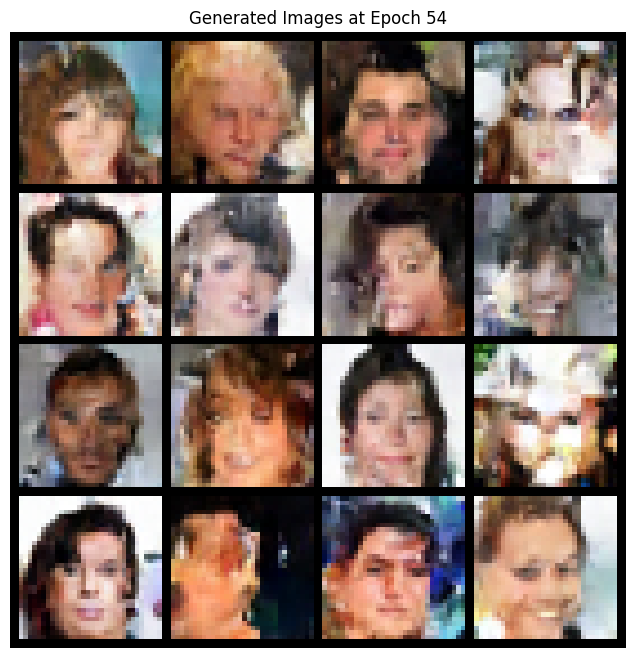

2025-06-23 06:52:53 - INFO - ------------------------------
2025-06-23 06:52:57 - INFO - Epoch: 55/60 | Batch: 0/318 | Loss (NLL): -8967.4590 | BPD: 3.7886
2025-06-23 06:55:20 - INFO - Epoch: 55/60 | Batch: 50/318 | Loss (NLL): -8875.2637 | BPD: 3.8319
2025-06-23 06:57:46 - INFO - Epoch: 55/60 | Batch: 100/318 | Loss (NLL): -8898.8350 | BPD: 3.8209
2025-06-23 07:00:13 - INFO - Epoch: 55/60 | Batch: 150/318 | Loss (NLL): -8923.6035 | BPD: 3.8092
2025-06-23 07:02:38 - INFO - Epoch: 55/60 | Batch: 200/318 | Loss (NLL): -8899.3711 | BPD: 3.8206
2025-06-23 07:05:03 - INFO - Epoch: 55/60 | Batch: 250/318 | Loss (NLL): -8909.7549 | BPD: 3.8157
2025-06-23 07:07:29 - INFO - Epoch: 55/60 | Batch: 300/318 | Loss (NLL): -8862.2422 | BPD: 3.8380
2025-06-23 07:08:18 - INFO - --- Epoch 55 Summary ---
2025-06-23 07:08:18 - INFO - Average Loss: -8905.0277 | Time: 925.48s
2025-06-23 07:08:18 - INFO - Generating sample images...


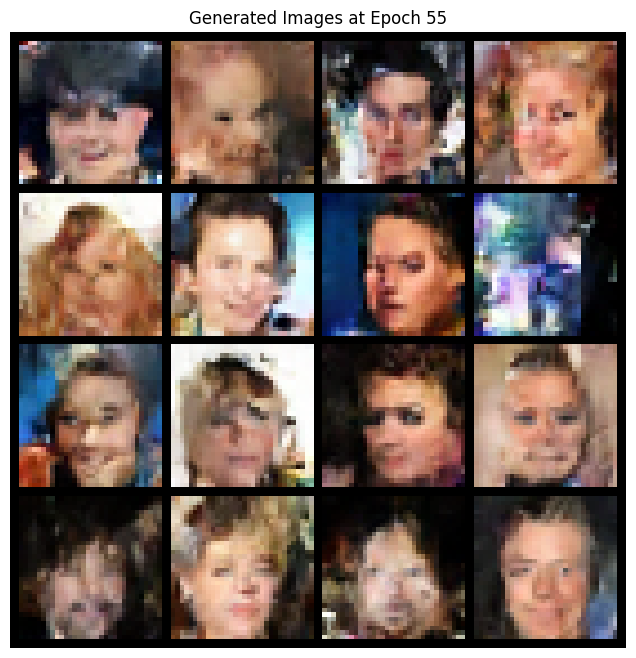

2025-06-23 07:08:19 - INFO - ------------------------------
2025-06-23 07:08:23 - INFO - Epoch: 56/60 | Batch: 0/318 | Loss (NLL): -8871.7266 | BPD: 3.8336
2025-06-23 07:10:48 - INFO - Epoch: 56/60 | Batch: 50/318 | Loss (NLL): -8896.8340 | BPD: 3.8218
2025-06-23 07:13:14 - INFO - Epoch: 56/60 | Batch: 100/318 | Loss (NLL): -9030.4961 | BPD: 3.7590
2025-06-23 07:15:40 - INFO - Epoch: 56/60 | Batch: 150/318 | Loss (NLL): -8951.1191 | BPD: 3.7963
2025-06-23 07:18:05 - INFO - Epoch: 56/60 | Batch: 200/318 | Loss (NLL): -8904.6982 | BPD: 3.8181
2025-06-23 07:20:33 - INFO - Epoch: 56/60 | Batch: 250/318 | Loss (NLL): -8944.6172 | BPD: 3.7994
2025-06-23 07:22:58 - INFO - Epoch: 56/60 | Batch: 300/318 | Loss (NLL): -8880.4219 | BPD: 3.8295
2025-06-23 07:23:47 - INFO - --- Epoch 56 Summary ---
2025-06-23 07:23:47 - INFO - Average Loss: -8907.0260 | Time: 928.88s
2025-06-23 07:23:47 - INFO - Generating sample images...


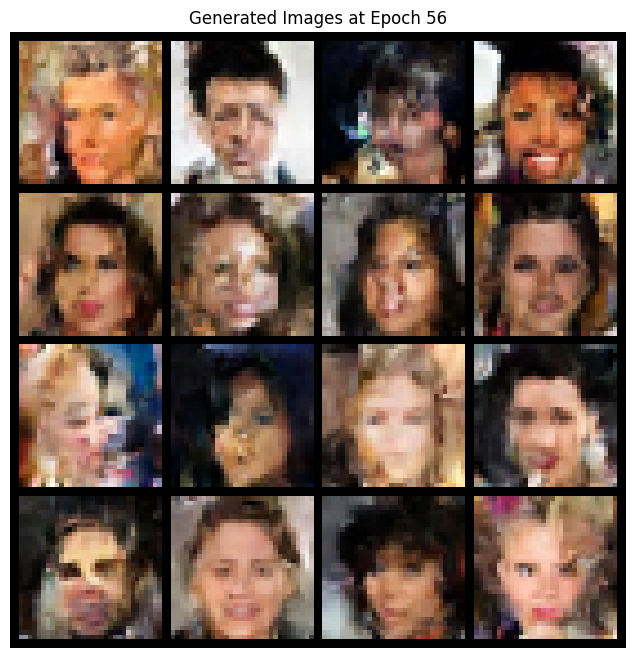

2025-06-23 07:23:48 - INFO - ------------------------------
2025-06-23 07:23:53 - INFO - Epoch: 57/60 | Batch: 0/318 | Loss (NLL): -8806.1582 | BPD: 3.8644
2025-06-23 07:26:19 - INFO - Epoch: 57/60 | Batch: 50/318 | Loss (NLL): -8976.5312 | BPD: 3.7844
2025-06-23 07:28:46 - INFO - Epoch: 57/60 | Batch: 100/318 | Loss (NLL): -8967.8701 | BPD: 3.7884
2025-06-23 07:31:11 - INFO - Epoch: 57/60 | Batch: 150/318 | Loss (NLL): -8895.8965 | BPD: 3.8222
2025-06-23 07:33:35 - INFO - Epoch: 57/60 | Batch: 200/318 | Loss (NLL): -8787.5469 | BPD: 3.8731
2025-06-23 07:36:00 - INFO - Epoch: 57/60 | Batch: 250/318 | Loss (NLL): -8895.3389 | BPD: 3.8225
2025-06-23 07:38:25 - INFO - Epoch: 57/60 | Batch: 300/318 | Loss (NLL): -8886.3770 | BPD: 3.8267
2025-06-23 07:39:14 - INFO - --- Epoch 57 Summary ---
2025-06-23 07:39:14 - INFO - Average Loss: -8920.4679 | Time: 926.04s
2025-06-23 07:39:14 - INFO - Generating sample images...


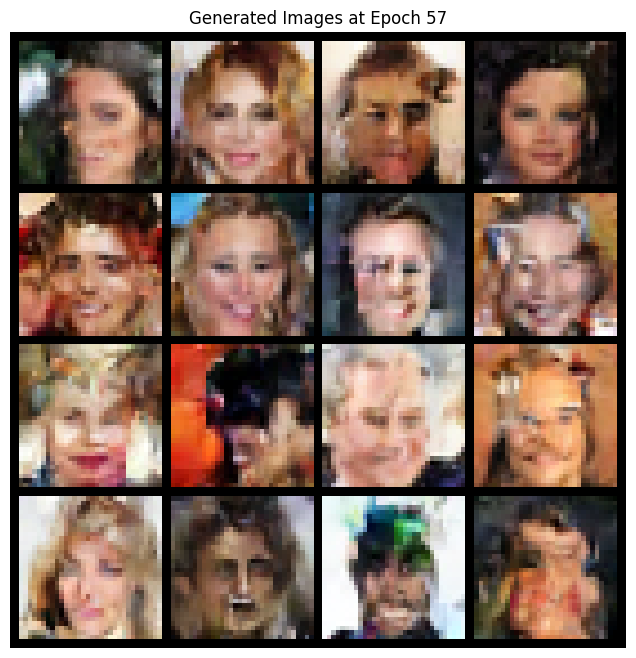

2025-06-23 07:39:15 - INFO - ------------------------------
2025-06-23 07:39:19 - INFO - Epoch: 58/60 | Batch: 0/318 | Loss (NLL): -8977.1777 | BPD: 3.7841
2025-06-23 07:41:44 - INFO - Epoch: 58/60 | Batch: 50/318 | Loss (NLL): -8964.9395 | BPD: 3.7898
2025-06-23 07:44:09 - INFO - Epoch: 58/60 | Batch: 100/318 | Loss (NLL): -8931.0664 | BPD: 3.8057
2025-06-23 07:46:34 - INFO - Epoch: 58/60 | Batch: 150/318 | Loss (NLL): -8961.5996 | BPD: 3.7914
2025-06-23 07:48:59 - INFO - Epoch: 58/60 | Batch: 200/318 | Loss (NLL): -8984.3984 | BPD: 3.7807
2025-06-23 07:51:24 - INFO - Epoch: 58/60 | Batch: 250/318 | Loss (NLL): -8974.4482 | BPD: 3.7854
2025-06-23 07:53:50 - INFO - Epoch: 58/60 | Batch: 300/318 | Loss (NLL): -8901.0596 | BPD: 3.8198
2025-06-23 07:54:39 - INFO - --- Epoch 58 Summary ---
2025-06-23 07:54:39 - INFO - Average Loss: -8926.7269 | Time: 924.61s
2025-06-23 07:54:39 - INFO - Generating sample images...


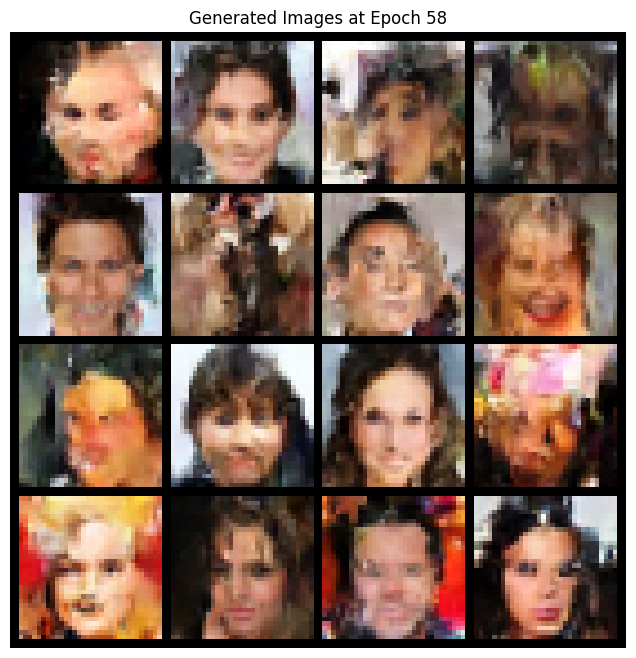

2025-06-23 07:54:40 - INFO - ------------------------------
2025-06-23 07:54:45 - INFO - Epoch: 59/60 | Batch: 0/318 | Loss (NLL): -8932.6797 | BPD: 3.8050
2025-06-23 07:57:10 - INFO - Epoch: 59/60 | Batch: 50/318 | Loss (NLL): -9011.0234 | BPD: 3.7682
2025-06-23 07:59:34 - INFO - Epoch: 59/60 | Batch: 100/318 | Loss (NLL): -8886.5625 | BPD: 3.8266
2025-06-23 08:02:01 - INFO - Epoch: 59/60 | Batch: 150/318 | Loss (NLL): -8939.2246 | BPD: 3.8019
2025-06-23 08:04:26 - INFO - Epoch: 59/60 | Batch: 200/318 | Loss (NLL): -8924.6055 | BPD: 3.8088
2025-06-23 08:06:51 - INFO - Epoch: 59/60 | Batch: 250/318 | Loss (NLL): -9008.5293 | BPD: 3.7693
2025-06-23 08:09:16 - INFO - Epoch: 59/60 | Batch: 300/318 | Loss (NLL): -8984.4316 | BPD: 3.7807
2025-06-23 08:10:05 - INFO - --- Epoch 59 Summary ---
2025-06-23 08:10:05 - INFO - Average Loss: -8927.9611 | Time: 925.25s
2025-06-23 08:10:05 - INFO - Generating sample images...


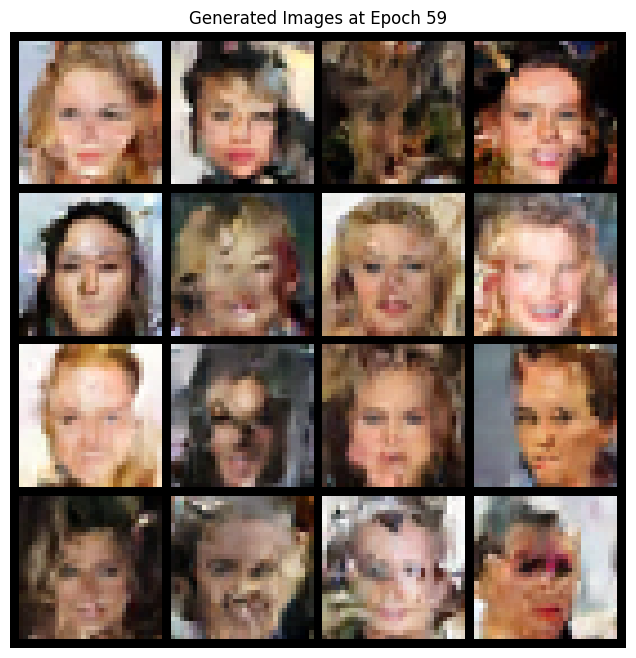

2025-06-23 08:10:06 - INFO - ------------------------------
2025-06-23 08:10:10 - INFO - Epoch: 60/60 | Batch: 0/318 | Loss (NLL): -8930.2480 | BPD: 3.8061
2025-06-23 08:12:35 - INFO - Epoch: 60/60 | Batch: 50/318 | Loss (NLL): -8940.8096 | BPD: 3.8012
2025-06-23 08:15:01 - INFO - Epoch: 60/60 | Batch: 100/318 | Loss (NLL): -8898.8906 | BPD: 3.8208
2025-06-23 08:17:26 - INFO - Epoch: 60/60 | Batch: 150/318 | Loss (NLL): -8931.7695 | BPD: 3.8054
2025-06-23 08:19:51 - INFO - Epoch: 60/60 | Batch: 200/318 | Loss (NLL): -8896.1797 | BPD: 3.8221
2025-06-23 08:22:16 - INFO - Epoch: 60/60 | Batch: 250/318 | Loss (NLL): -8856.5127 | BPD: 3.8407
2025-06-23 08:24:41 - INFO - Epoch: 60/60 | Batch: 300/318 | Loss (NLL): -8983.3086 | BPD: 3.7812
2025-06-23 08:25:30 - INFO - --- Epoch 60 Summary ---
2025-06-23 08:25:30 - INFO - Average Loss: -8932.4149 | Time: 924.81s
2025-06-23 08:25:30 - INFO - Generating sample images...


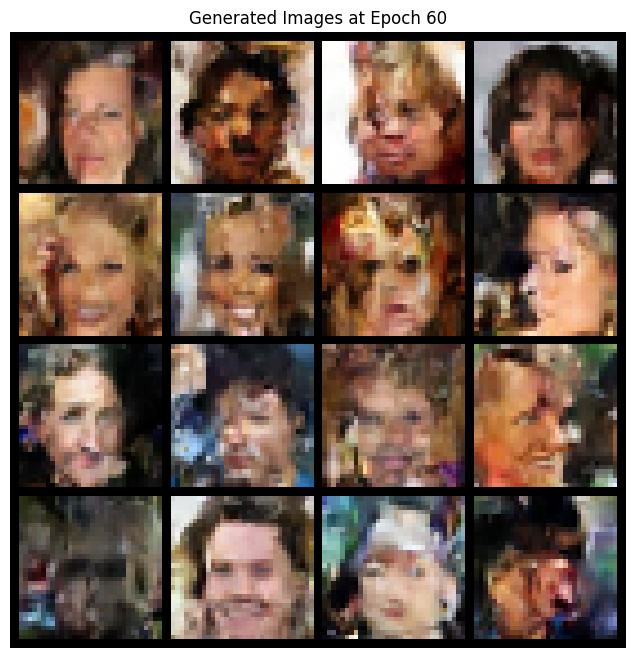

2025-06-23 08:25:31 - INFO - ------------------------------


In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "laplace"
prior = PriorDistribution(dist_type=prior_str)

logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)

try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
# Assuming 'flow' is your trained model object
from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

# Use model.state_dict() to get the dictionary of weights
torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

Saving model weights to rg_flow_weights_2025-06-23_08-26-05_60_laplace.pth...
Model weights saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
# Download the generated images directory
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

  adding: generated_images/ (stored 0%)
  adding: generated_images/epoch_042.png (deflated 9%)
  adding: generated_images/epoch_008.png (deflated 9%)
  adding: generated_images/epoch_058.png (deflated 9%)
  adding: generated_images/epoch_048.png (deflated 9%)
  adding: generated_images/epoch_019.png (deflated 9%)
  adding: generated_images/epoch_031.png (deflated 9%)
  adding: generated_images/epoch_003.png (deflated 9%)
  adding: generated_images/epoch_036.png (deflated 9%)
  adding: generated_images/epoch_057.png (deflated 9%)
  adding: generated_images/epoch_046.png (deflated 9%)
  adding: generated_images/epoch_015.png (deflated 9%)
  adding: generated_images/epoch_060.png (deflated 9%)
  adding: generated_images/epoch_035.png (deflated 9%)
  adding: generated_images/epoch_052.png (deflated 9%)
  adding: generated_images/epoch_032.png (deflated 9%)
  adding: generated_images/epoch_005.png (deflated 9%)
  adding: generated_images/epoch_002.png (deflated 9%)
  adding: generated_image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")


files.download(optimizer_path)

Saving optimizer state to rg_flow_optimizer_2025-06-23_08-25-40_60_laplace.pth...
Optimizer state saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>